In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import agama
from astropy.io import fits
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from matplotlib import patches

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

figpath = 'figs/'
datapath = 'data/'
simpath = 'sims/'
agama_pot_path = 'agama_potentials/'


In [5]:
'''Import DR3 data'''

hdu = fits.open(datapath+'rvs_data_feh2_parsn3.fits', memmap=True)
t = Table.read(hdu)

In [6]:
'''Transform and cut data'''

coords = coord.SkyCoord(ra=t['RA']*u.deg, dec=t['DEC']*u.deg, distance=t['DIST']*u.kpc, pm_ra_cosdec=t['PMRA']*u.mas/u.yr, pm_dec=t['PMDEC']*u.mas/u.yr, radial_velocity=t['VLOS']*u.km/u.s)

galcen_v_sun = np.array([11.1, 247.4, 7.25])*u.km/u.s#(12.9, 245.6, 7.78)

R_sun = 8.178

coords = coords.transform_to(coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))

ic = np.array([coords.x.value, coords.y.value, coords.z.value, coords.v_x.value, coords.v_y.value, coords.v_z.value]).T

# Convert to coordinate system where Sun is at x=+8.178kpc, Galactic rotation in +y direction
ic = ic*np.array([-1, 1, 1, -1, 1, 1])

# Perform quality cuts
parsn = t['PARSN']
dist = t['DIST']
MH = t['MH']
logg = t['LOGG']

parsn_min = 10
dist_max = 100

cut = (parsn > parsn_min) * (dist < dist_max)

ic = ic[cut]
MH = MH[cut]
logg = logg[cut]
dist = dist[cut]
parsn = parsn[cut]


In [7]:
'''Remove large variables to save memory'''
del hdu, t, coords, cut

In [8]:
'''Calculate data quantities'''

R_data = np.linalg.norm(ic[:,0:2], axis=1)
phi_data_sun = np.arctan2(ic[:,1], ic[:,0])
z_data = ic[:,2]

R_hat = ic[:,0:3] * [1, 1, 0] / R_data[:,None]
vR_data = (ic[:,3:6] * R_hat).sum(axis=1)
phi_hat = np.cross([0,0,1], R_hat)
vphi_data = (ic[:,3:6] * phi_hat).sum(axis=1)

# Remove large variables to save memory
del R_hat, phi_hat

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/numpy/lib/histograms.py:1066: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


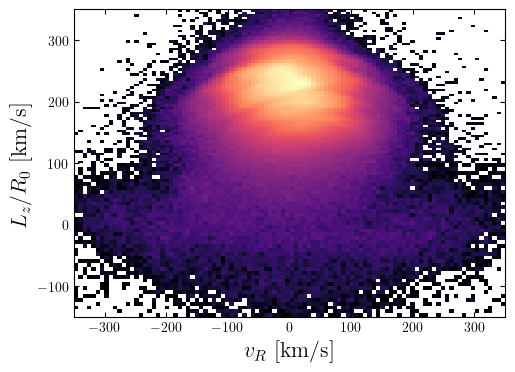

In [9]:
'''Plot velocity space in the disc'''

cut = (abs(R_data - R_sun) < 0.5)*(abs(phi_data_sun) < np.pi/12)*(abs(z_data) < 1)#*(logg < 3)

vR_bins = np.linspace(-350, 350, 101)
vphi_bins = np.concatenate((np.linspace(-150, 100, 41), np.linspace(100, 350, 61)))

fig, ax = plt.subplots(figsize=(6,4))

ax.hist2d(vR_data[cut], vphi_data[cut]*R_data[cut]/R_sun, bins=(vR_bins, vphi_bins), norm=mcolors.LogNorm(), density=True, cmap='magma')

ax.set_xlabel('$v_R$ [km/s]', fontsize=16)
ax.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)
ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

ax.set_aspect('equal')

In [10]:
'''Choose potential'''
pot_axi = agama.Potential(agama_pot_path+'MWPotentialHunter24_axi.ini')
pot_bar = agama.Potential(agama_pot_path+'MWPotentialHunter24_full.ini')

In [11]:
'''Calculate energy and angular momentum'''

# Calculate energy
E_data = 0.5 * (ic[:,3:6]**2).sum(axis=1) + pot_axi.potential(ic[:,0:3])

# Calculate angular momentum
Lz_data = np.cross(ic[:,0:3], ic[:,3:6], axis=1)[:,2]


In [16]:
'''Load simulation'''

o = np.load(simpath+'trajs_Hunter.npy', allow_pickle=True)

In [17]:
'''Calculate simulation quantities'''
from scipy.integrate import quad

# Functions to calculate pattern speed and bar angle
def calc_Omega_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    
    Omega_b_2 = Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t2 - t1))
    
    if t <= t1:
        return Omega_b_1
    
    elif (t > t1)*(t <= t2):
        return Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t - t1)**2 / (t2 - t1))
    
    elif t > t2:
        return Omega_b_2 / (1 + eta * Omega_b_2 * (t - t2))

def calc_phi_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    phi_b = quad(calc_Omega_b, 0, t, args=(Omega_b_1, eta, t0, t1, t2, tf))[0]
    return phi_b

# Simulation parameters (CAREFUL THAT THEY MATCH THE SIMULATION SETUP)
# Potential parameters
R_sun_sim = 8.178
vcirc_sun_sim = 229 #236.9

# Sun's position
bar_angle = np.pi/6
phi_sun = -bar_angle
X_sun = R_sun * np.cos(phi_sun)
Y_sun = R_sun * np.sin(phi_sun)

# Bar parameters
t0 = 0  # Start of bar growth
t1 = 2  # End of bar growth
t2 = 3
tf = 8 # End of simulation
Omega_b_1 = 60
0 # Initial pattern speed (in km/s/kpc)
eta = 0.003 # Deceleration rate

# Calculate simulation coordinates
ts = o[:,0][0]
trajs = np.stack(o[:,1]).transpose((1,0,2))

# Delete original array to save memory
del o

# Calculate pattern speed and bar angle
Omega_b_sim = np.zeros(len(ts))
phi_b_sim = np.zeros(len(ts))

for i in range(len(ts)):
    Omega_b_sim[i] = calc_Omega_b(ts[i], Omega_b_1, eta, t0, t1, t2, tf)
    phi_b_sim[i] = calc_phi_b(ts[i], Omega_b_1, eta, t0, t1, t2, tf)

In [54]:
'''Calculate simulation coordinates'''

# Calculate cylindrical coordinates
R_sim = np.linalg.norm(trajs[:,:,0:2], axis=-1)
phi_sim = (np.arctan2(trajs[:,:,1], trajs[:,:,0]) - phi_b_sim[:,None] + np.pi)%(2*np.pi) - np.pi
phi_sim_sun = (np.arctan2(trajs[:,:,1], trajs[:,:,0]) - phi_b_sim[:,None] - phi_sun + np.pi/2)%(np.pi) - np.pi/2

R_hat = trajs[:,:,0:3] * [1, 1, 0] / R_sim[:,:,None]
phi_hat = np.cross([0,0,1], R_hat)
vR_sim = (trajs[:,:,3:6] * R_hat).sum(axis=-1)
vphi_sim = (trajs[:,:,3:6] * phi_hat).sum(axis=-1)

# Calculate coordinates in bar's frame
X_sim = R_sim * np.cos(phi_sim)
Y_sim = R_sim * np.sin(phi_sim)
z_sim = trajs[:,:,2]

# Angular momentum
Lz_sim = np.cross(trajs[:,:,0:3], trajs[:,:,3:6])[:,:,2]

# Distance from Sun
dist_sim = ((X_sim - X_sun)**2 + (Y_sim - Y_sun)**2 + z_sim**2)**0.5

In [18]:
'''Select fiducial simulation snapshot'''

snap = -2

Omega_b = Omega_b_sim[snap]

print('Fiducial pattern speed Omega_b =', Omega_b, 'km/s/kpc')

Fiducial pattern speed Omega_b = 32.50270916353844 km/s/kpc


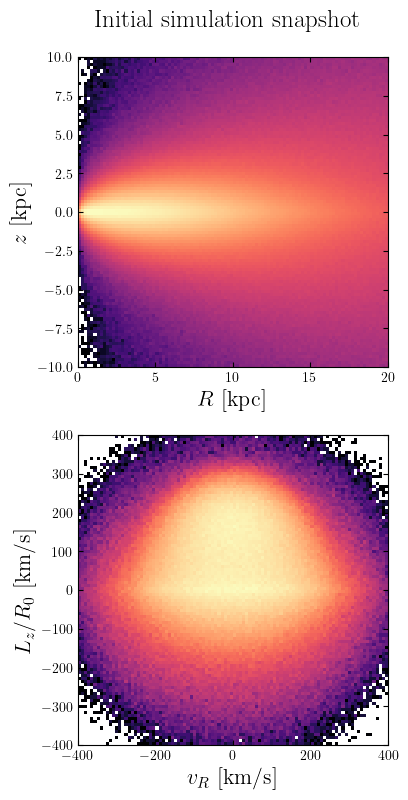

In [64]:
'''Initial velocity distribution of simulation'''

R_range = 1
z_max = 2

cut = (abs(R_sim[0] - R_sun) < R_range)*(abs(z_sim[0]) < z_max)

bins = np.linspace(-400, 400, 101)
Rbins = np.linspace(0, 20, 101)
zbins = np.linspace(-10, 10, 101)

fig, axs = plt.subplots(2, figsize=(4,9))

hist, _, _ = np.histogram2d(R_sim[0], z_sim[0], bins=(Rbins, zbins))
axs[0].imshow(hist.T, extent=(Rbins[0], Rbins[-1], zbins[0], zbins[-1]), origin='lower', interpolation='nearest', norm=mcolors.LogNorm(), cmap='magma')

hist, _, _ = np.histogram2d(vR_sim[0,cut], vphi_sim[0,cut]*R_sim[0,cut]/R_sun, bins=bins)
axs[1].imshow(hist.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', norm=mcolors.LogNorm(), cmap='magma')

axs[0].set_xlabel('$R$ [kpc]', fontsize=16)
axs[0].set_ylabel('$z$ [kpc]', fontsize=16)

axs[1].set_xlabel('$v_R$ [km/s]', fontsize=16)
axs[1].set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)

fig.suptitle('Initial simulation snapshot', fontsize=18, y=0.93)

for ax in axs.flat:
    ax.set_aspect('equal')
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
    ax.set_rasterization_zorder(10)

plt.savefig(figpath+'sim_initial.pdf', dpi=200, bbox_inches='tight')


In [81]:
'''Load Andrae RGB sample'''

hdu_RGB = fits.open(datapath+'table_2_catwise.fits', memmap=True)
t_RGB = Table.read(hdu_RGB)

In [82]:
'''Transform and cut RGB sample data'''

coords_RGB = coord.SkyCoord(ra=t_RGB['ra']*u.deg, dec=t_RGB['dec']*u.deg, distance=1/t_RGB['parallax']*u.kpc, pm_ra_cosdec=t_RGB['pmra']*u.mas/u.yr, pm_dec=t_RGB['pmdec']*u.mas/u.yr, radial_velocity=t_RGB['radial_velocity']*u.km/u.s)

coords_RGB = coords_RGB.transform_to(coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))

ic_RGB = np.array([coords_RGB.x.value, coords_RGB.y.value, coords_RGB.z.value, coords_RGB.v_x.value, coords_RGB.v_y.value, coords_RGB.v_z.value]).T

# Convert to coordinate system where Sun is at x=+8.178kpc, Galactic rotation in +y direction
ic_RGB = ic_RGB*np.array([-1, 1, 1, -1, 1, 1])

# Perform quality cuts
parsn_RGB = t_RGB['parallax']/t_RGB['parallax_error']
dist_RGB = 1/t_RGB['parallax']
MH_RGB = t_RGB['mh_xgboost']
# logg = t_RGB['LOGG']

parsn_min = 10
dist_max = 100

cut = (parsn_RGB > parsn_min) * (dist_RGB < dist_max)

ic_RGB = ic_RGB[cut]
MH_RGB = MH_RGB[cut]

R_RGB = np.linalg.norm(ic_RGB[:,0:2], axis=1)
phi_RGB_sun = np.arctan2(ic_RGB[:,1], ic_RGB[:,0])
z_RGB = ic_RGB[:,2]

R_hat = ic_RGB[:,0:3] * [1, 1, 0] / R_RGB[:,None]
vR_RGB = (ic_RGB[:,3:6] * R_hat).sum(axis=1)
phi_hat = np.cross([0,0,1], R_hat)
vphi_RGB = (ic_RGB[:,3:6] * phi_hat).sum(axis=1)

Lz_RGB = R_RGB * vphi_RGB 


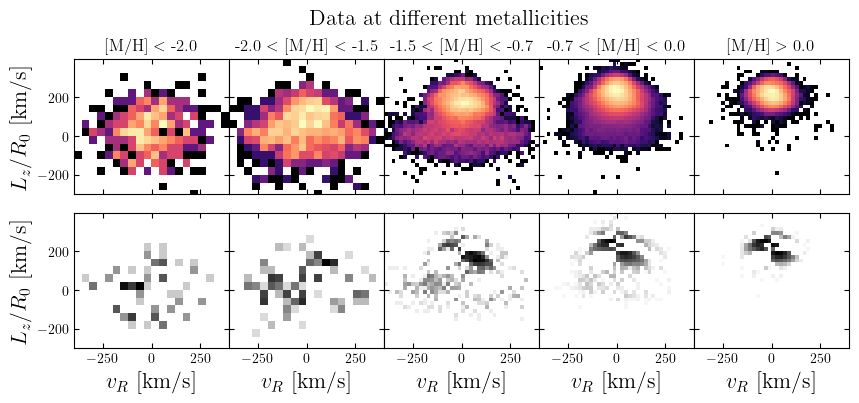

In [89]:
'''Plot RGB in different metallicity/position bins'''

# Select radial, azimuthal and metallicity ranges in which to plot
R_range = 1
phi_range = np.pi/12
z_max = 2
MH_max = 100

MH_bins = np.array([-100, -2, -1.5, -0.7, 0, 100])
R_bins = np.linspace(5, 12, 8)

fig, axs = plt.subplots(2, len(MH_bins)-1, figsize=(10,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0., hspace=0.)


for i in range(len(MH_bins)-1):
# for i in range(len(R_bins)-1):
    
    if i<2:
        bins = np.linspace(-400, 400, 21)
    
    else:
        bins = np.linspace(-400, 400, 41) 
    
    cut = (MH_RGB > MH_bins[i])*(MH_RGB < MH_bins[i+1])*(abs(R_RGB - R_sun) < R_range)*(abs(phi_RGB_sun) < phi_range)*(abs(z_RGB) < z_max)#*(eta_RGB<0.99)
    # cut = (MH < -1)*(abs(phi_RGB_sun)<np.pi/24)*(R_RGB > R_bins[i])*(R_RGB < R_bins[i+1])

    hist, _, _ = np.histogram2d(vR_RGB[cut], vphi_RGB[cut]*R_RGB[cut]/R_sun, bins=bins)
    
    axs[0,i].imshow(hist.T, extent=(bins[0],bins[-1],bins[0],bins[-1]), interpolation='nearest', origin='lower', norm=mcolors.LogNorm(), cmap='magma')
    
    hist_antisym = (hist - np.flip(hist, axis=0))#/(hist + np.flip(hist, axis=0))
    
    axs[1,i].imshow(hist_antisym.T, extent=(bins[0],bins[-1],bins[0],bins[-1]), interpolation='nearest', origin='lower', norm=mcolors.LogNorm(), cmap='Greys')
    # axs[1,i].imshow(hist_antisym.T, extent=(bins[0],bins[-1],bins[0],bins[-1]), interpolation='none', origin='lower', norm=mcolors.LogNorm(vmax=100), cmap='Greys')
    
    # axs[i].hist2d(vr_RGB[cut], vphi_RGB[cut], bins=bins, norm=mcolors.LogNorm())
    axs[1,i].set_xlabel('$v_R$ [km/s]', fontsize=16)

    if i==0:
        axs[0,i].set_title('[M/H] $<$ '+str(MH_bins[i+1]))
    
    elif i==len(MH_bins)-2:
        axs[0,i].set_title('[M/H] $>$ '+str(MH_bins[i]))

    else:
        axs[0,i].set_title(str(MH_bins[i])+' $<$ [M/H] $<$ '+str(MH_bins[i+1]))


for ax in axs[:,0].flat:
    ax.set_ylim(-299, 399)
    ax.set_aspect('equal')
    ax.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)

for ax in axs.flat:
    ax.set_xlim(-399, 399)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
    ax.set_rasterization_zorder(10)

plt.suptitle('Data at different metallicities', fontsize=16)

plt.savefig(figpath+'data_metallicity.pdf', dpi=200, bbox_inches='tight')

plt.show()
plt.close()


Omega_b =  32.50270916353844


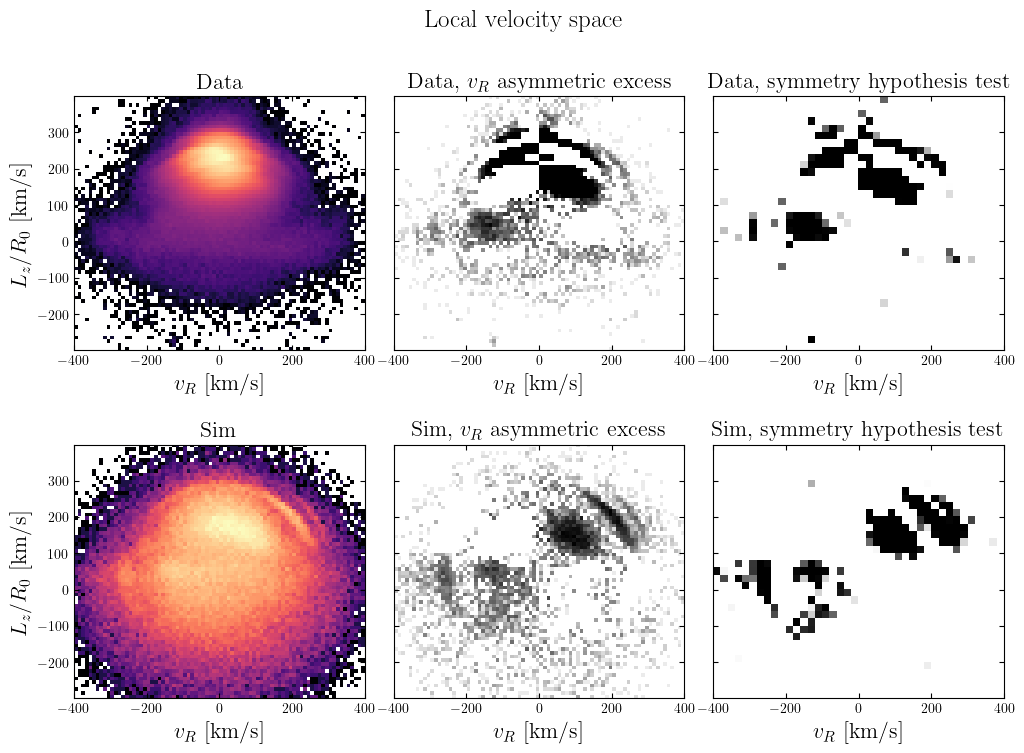

In [17]:

'''Plot antisymmetric distribution of data and simulation'''

from scipy.ndimage import gaussian_filter, maximum_filter
from skimage.feature import peak_local_max
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import binomtest

fig, axs = plt.subplots(2,3, figsize=(12,8), sharex='row', sharey='row')#, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.3)

# Select radial, azimuthal and metallicity ranges in which to plot
R_range = 1
phi_range = np.pi/12
z_max = 2
MH_max = 100

# Choose simulation snapshot
snap = -2
print('Omega_b = ', Omega_b_sim[snap])

# Data
# cut_all = (abs(R_data - R_sun) < R_range)*(abs(phi_data_sun) < phi_range)#(dist<dist_limit_all)#*(eta_data<0.98)#*(logg<3)
cut = (MH < MH_max)*(abs(R_data - R_sun) < R_range)*(abs(phi_data_sun) < phi_range)*(abs(z_data) < z_max)#(dist<dist_limit)

bins = np.linspace(-400, 400, 81)

# hist_all, _, _ = np.histogram2d(vR_data[cut_all], vphi_data[cut_all], bins=bins)
hist, _, _ = np.histogram2d(vR_data[cut], vphi_data[cut]*R_data[cut]/R_sun, bins=bins)
hist_sym = hist + np.flip(hist, axis=0)
hist_antisym = hist - np.flip(hist, axis=0)
# hist_antisym = gaussian_filter(hist_antisym, 0.5)

# axs[0,0].imshow(hist_all.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='viridis')
axs[0,0].imshow(hist.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', norm=mcolors.LogNorm(), cmap='magma')
axs[0,1].imshow(hist_antisym.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', norm=mcolors.LogNorm(vmax=100), cmap='Greys')

# Hypothesis test for symmetry
bins = np.linspace(-400, 400, 41)
hist, _, _ = np.histogram2d(vR_data[cut], vphi_data[cut]*R_data[cut]/R_sun, bins=bins)
hist_sym = hist + np.flip(hist, axis=0)
pvalue_array = np.zeros(hist.shape)

for i in range(pvalue_array.shape[0]):
    for j in range(pvalue_array.shape[1]):
        n = int(hist_sym[i,j])
        k = int(hist[i,j])
        if n>1:
            pvalue_array[i,j] = 1 - binomtest(k, n, p=0.5, alternative='greater').pvalue

axs[0,2].imshow(pvalue_array.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', vmin=0.99, vmax=1, cmap='Greys')

# Simulation
# cut_0 = (abs(R_sim[0] - R_sun) < R_range)*(abs(phi_sim[0]%np.pi - 5/6*np.pi) < phi_range)
cut = (abs(R_sim[snap] - R_sun) < R_range)*(abs(phi_sim_sun[snap]) < phi_range)*(abs(z_sim[snap]) < z_max)

bins = np.linspace(-400, 400, 81)

# hist_0, _, _ = np.histogram2d(vR_sim[0,cut_0], vphi_sim[0,cut_0], bins=bins)
hist, _, _ = np.histogram2d(vR_sim[snap,cut], vphi_sim[snap,cut]*R_sim[snap,cut]/R_sun, bins=bins)
hist_sym = hist + np.flip(hist, axis=0)
hist_antisym = hist - np.flip(hist, axis=0)
# hist_antisym = gaussian_filter(hist_antisym, 0.5)

# axs[1,0].imshow(hist_0.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='viridis')
axs[1,0].imshow(hist.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', norm=mcolors.LogNorm(), cmap='magma')
axs[1,1].imshow(hist_antisym.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', norm=mcolors.LogNorm(), cmap='Greys')

# Hypothesis test for symmetry
bins = np.linspace(-400, 400, 41)
hist, _, _ = np.histogram2d(vR_sim[snap,cut], vphi_sim[snap,cut]*R_sim[snap,cut]/R_sun, bins=bins)
hist_sym = hist + np.flip(hist, axis=0)
pvalue_array = np.zeros(hist.shape)

for i in range(pvalue_array.shape[0]):
    for j in range(pvalue_array.shape[1]):
        n = int(hist_sym[i,j])
        k = int(hist[i,j])
        if n>1:
            pvalue_array[i,j] = 1 - binomtest(k, n, p=0.5, alternative='greater').pvalue

axs[1,2].imshow(pvalue_array.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', vmin=0.99, vmax=1, cmap='Greys')

for ax in axs[:,0].flat:
    ax.set_ylim(-299, 399)
    ax.set_aspect('equal')
    ax.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)

for ax in axs.flat:
    # ax.set_xlim(-399, 399)
    ax.set_xlabel('$v_R$ [km/s]', fontsize=16)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
    ax.set_rasterization_zorder(10)


# axs[0,0].set_title('Data', fontsize=16)
axs[0,0].set_title('Data', fontsize=16)
axs[0,1].set_title('Data, $v_R$ asymmetric excess', fontsize=16)
axs[0,2].set_title('Data, symmetry hypothesis test', fontsize=16)

# axs[1,0].set_title('Simulation, initial', fontsize=16)
axs[1,0].set_title('Sim', fontsize=16)
axs[1,1].set_title('Sim, $v_R$ asymmetric excess', fontsize=16)
axs[1,2].set_title('Sim, symmetry hypothesis test', fontsize=16)


fig.suptitle('Local velocity space', fontsize=18, y=0.98)

# axs[0].set_title('$[M/H]<-1$, distance $<1$ kpc', fontsize=16)
# axs[1].set_title('$v_R$ asymmetric excess', fontsize=16)
# plt.xlim(-350, -200)
# plt.ylim(-100, 100)

# plt.savefig(figpath+'data_sim.pdf', dpi=200, bbox_inches='tight')

plt.show()

del hist, hist_antisym, cut

In [18]:
'''Function to calculate radial phase space track of resonant orbit'''

from scipy.interpolate import CubicSpline

def calc_res_orbit(pot, Omega_b, res_ratio, Lz, E_offset=0):
    # Create ActionFinder to compute frequencies
    # af = agama.ActionFinder(pot)

    # Make grid of initial conditions at Sun's radius
    N_grid = 41
    vR_grid = np.linspace(1, 400, N_grid)
    ic = np.array([R_sun*np.ones(N_grid), np.zeros(N_grid), np.zeros(N_grid), vR_grid, Lz/R_sun*np.ones(N_grid), 1e-1*np.ones(N_grid)]).T

    o = agama.orbit(ic=ic, potential=pot, Omega=Omega_b, time=1, trajsize=1001, verbose=False)
    ts = o[:,0][0]
    orbits = np.stack(o[:,1]).transpose((1,0,2))
    
    R_orbits = np.linalg.norm(orbits[:,:,0:2], axis=-1)
    R_hat = orbits[:,:,0:3] * [1, 1, 0] / R_orbits[:,:,None]
    vR_orbits = (orbits[:,:,3:6] * R_hat).sum(axis=-1)
    
    
    phi_orbits = np.arctan2(orbits[:,:,1], orbits[:,:,0]) + Omega_b * ts[:,None]

    phi_orbits_unwrap = np.unwrap(phi_orbits, axis=0)

    apo_indices = np.where((vR_orbits[:-1] > 0)*(vR_orbits[1:] < 0))

    # Calculate radial periods and frequencies
    T_R = np.full(vR_orbits.shape[1], np.nan)
    Omega_phi = np.full(vR_orbits.shape[1], np.nan)

    

    for m in range(vR_orbits.shape[1]):
        column_true_indices = apo_indices[0][apo_indices[1] == m]  # Get the indices of True values in column m
        if len(column_true_indices) >= 2:
            T_R[m] = (column_true_indices[1] - column_true_indices[0]) * (ts[1] - ts[0])
            Omega_phi[m] = (phi_orbits_unwrap[column_true_indices[1],m] - phi_orbits_unwrap[column_true_indices[0],m]) / (ts[column_true_indices[1]] - ts[column_true_indices[0]])
    
    Omega_R = 2*np.pi / T_R

    freq_ratio = -(Omega_phi - Omega_b)/Omega_R

    vR_grid_fine = np.linspace(vR_grid[0], vR_grid[-1], 1001)
    freq_ratio_inter = np.interp(vR_grid_fine, vR_grid, freq_ratio)


    # act, ang, freq = af(ic, angles=True)

    # freq_ratio = -(freq[:,2] - Omega_b)/freq[:,0]

    vR_func_list = []

    res_dist = abs(freq_ratio_inter - res_ratio)

    res_index = np.nanargmin(res_dist)
    res_ic = ic[0]

    res_ic[3] = (vR_grid_fine[res_index]**2 + 2*E_offset)**0.5

    res_orbit = agama.orbit(ic=res_ic, potential=pot, Omega=Omega_b, time=1, trajsize=1001)[1]

    R_orbit = np.linalg.norm(res_orbit[:,0:2], axis=-1)
    R_hat = res_orbit[:,0:3] * [1, 1, 0] / R_orbit[:,None]
    vR_orbit = (res_orbit[:,3:6] * R_hat).sum(axis=-1)

    # try:
    first_apo_index = np.where((vR_orbit[:-1] > 0)*(vR_orbit[1:] < 0))[0][0]
    first_peri_index = np.where((vR_orbit[:-1] < 0)*(vR_orbit[1:] > 0))[0][0]

    R_orbit_cut = R_orbit[first_apo_index+1:first_peri_index-1]
    vR_orbit_cut = vR_orbit[first_apo_index+1:first_peri_index-1]

    vR_func = CubicSpline(np.flip(R_orbit_cut), np.flip(-abs(vR_orbit_cut)), extrapolate=False)

    return vR_func

<>:118: SyntaxWarning: invalid escape sequence '\p'
<>:118: SyntaxWarning: invalid escape sequence '\p'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_77689/2427100011.py:118: SyntaxWarning: invalid escape sequence '\p'
  fig.suptitle('Radial phase space ($\phi\\approx\phi_\odot$, $0<L_z<500$ kpc km/s)', fontsize=18, y=0.98)


Omega_b =  32.50270916353844


/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_77689/2427100011.py:27: RuntimeWarning: invalid value encountered in divide
  hist_smooth_colnorm = hist_smooth / hist_smooth.sum(axis=1)[:,None]


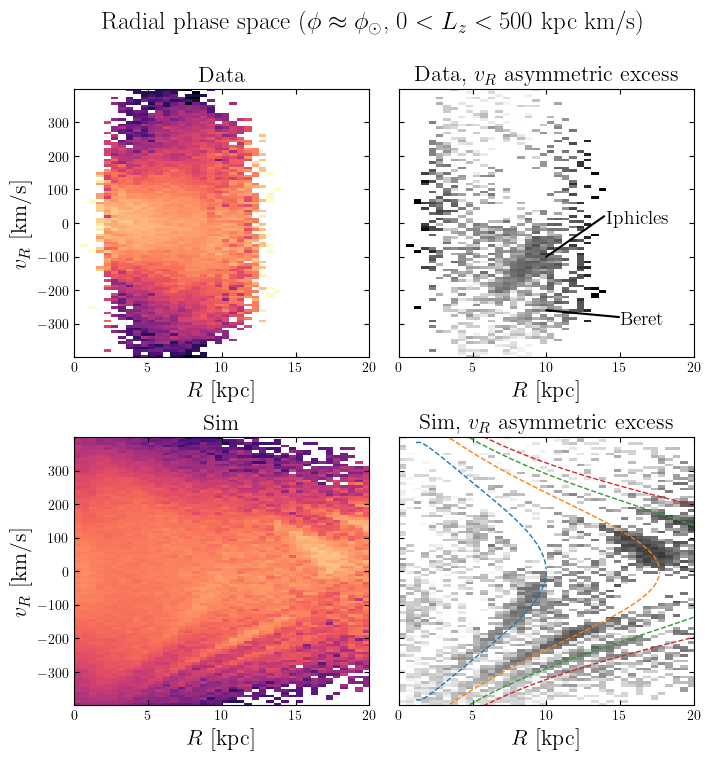

In [19]:
'''Plot radial phase space'''

from scipy.ndimage import gaussian_filter
from scipy.stats import binomtest

fig, axs = plt.subplots(2,2, figsize=(8,8), sharex='row', sharey='row')#, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.3)

# Select Lz, azimuthal and metallicity ranges in which to plot
Lz_max = 500
phi_range = np.pi/12
z_max = 2
MH_max = 100

# Choose simulation snapshot
snap = -2
print('Omega_b = ', Omega_b_sim[snap])

# Data
cut = (Lz_data > 0)*(Lz_data < Lz_max)*(abs(phi_data_sun) < phi_range)*(abs(z_data) < z_max)#(dist<dist_limit_all)#*(eta_data<0.98)#*(logg<3)

R_bins = np.linspace(0, 20, 41)
vR_bins = np.linspace(-400, 400, 101)

hist, _, _ = np.histogram2d(R_data[cut], vR_data[cut], bins=(R_bins, vR_bins))
hist_smooth = gaussian_filter(hist, (0,0))
hist_smooth_colnorm = hist_smooth / hist_smooth.sum(axis=1)[:,None]
# hist_smooth_colnorm[np.isnan(hist_smooth_colnorm)] = 0
hist_sym = hist + np.flip(hist, axis=1)
hist_smooth_antisym = hist_smooth_colnorm - np.flip(hist_smooth_colnorm, axis=1)
# hist_antisym = gaussian_filter(hist_antisym, 1)


# axs[0,0].imshow(hist_all.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='viridis')
axs[0,0].imshow(hist_smooth_colnorm.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='magma')
axs[0,1].imshow(hist_smooth_antisym.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='Greys')

# # Hypothesis test for symmetry
# pvalue_array = np.zeros(hist.shape)

# for i in range(pvalue_array.shape[0]):
#     for j in range(pvalue_array.shape[1]):
#         n = int(hist_sym[i,j])
#         k = int(hist[i,j])
#         if n>1:
#             pvalue_array[i,j] = 1 - binomtest(k, n, p=0.5, alternative='greater').pvalue

# axs[0,2].imshow(pvalue_array.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', vmin=0.9, vmax=1, cmap='Greys')

# Simulation
cut = (Lz_sim[snap] > 0)*(Lz_sim[snap] < Lz_max)*(abs(phi_sim_sun[snap]) < phi_range)*(abs(z_sim[snap]) < z_max)

hist, _, _ = np.histogram2d(R_sim[snap,cut], vR_sim[snap,cut], bins=(R_bins, vR_bins))
hist_smooth = gaussian_filter(hist, (0,0))
hist_smooth_colnorm = hist_smooth / hist_smooth.sum(axis=1)[:,None]
hist_sym = hist + np.flip(hist, axis=1)
hist_smooth_antisym = hist_smooth_colnorm - np.flip(hist_smooth_colnorm, axis=1)
# hist_antisym = gaussian_filter(hist_antisym, (0,0.5))
# hist_antisym = gaussian_filter(hist_antisym, 0.5)

# axs[1,0].imshow(hist_0.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='viridis')
axs[1,0].imshow(hist_smooth_colnorm.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='magma')
axs[1,1].imshow(hist_smooth_antisym.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='Greys')

# # Hypothesis test for symmetry
# pvalue_array = np.zeros(hist.shape)

# for i in range(pvalue_array.shape[0]):
#     for j in range(pvalue_array.shape[1]):
#         n = int(hist_sym[i,j])
#         k = int(hist[i,j])
#         if n>1:
#             pvalue_array[i,j] = 1 - binomtest(k, n, p=0.5, alternative='greater').pvalue

# axs[1,2].imshow(pvalue_array.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', vmin=0.9, vmax=1, cmap='Greys')

res_ratio_list = [0, 0.5, 1, 1.5]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
R_grid = np.linspace(0, 20, 10001)
for j in range(len(res_ratio_list)):
    vR_res = calc_res_orbit(pot_axi, Omega_b_sim[snap], res_ratio_list[j], 250)
    axs[1,1].plot(R_grid, vR_res(R_grid), ls='--', c=colors[j], lw=1)
    axs[1,1].plot(R_grid, -vR_res(R_grid), ls='--', c=colors[j], lw=1)

    # axs[0,1].plot(R_grid, vR_res(R_grid), ls='--', c=colors[j], lw=1)
    # axs[0,1].plot(R_grid, -vR_res(R_grid), ls='--', c=colors[j], lw=1)


for ax in axs[:,0].flat:
    ax.set_ylim(-399, 399)
    # ax.set_aspect('equal')
    ax.set_ylabel('$v_R$ [km/s]', fontsize=16)

for ax in axs.flat:
    ax.set_xlim(0, 20)
    ax.set_xlabel('$R$ [kpc]', fontsize=16)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
    ax.set_rasterization_zorder(10)


axs[0,1].text(14, 0, 'Iphicles', fontsize=14)
axs[0,1].text(15, -300, 'Beret', fontsize=14)

axs[0,1].plot([10,13.9], [-100, 20], c='k')
axs[0,1].plot([10,14.9], [-260, -280], c='k')

# axs[0,0].set_title('Data', fontsize=16)
axs[0,0].set_title('Data', fontsize=16)
axs[0,1].set_title('Data, $v_R$ asymmetric excess', fontsize=16)
# axs[0,2].set_title('Data, symmetry hypothesis test', fontsize=16)

# axs[1,0].set_title('Simulation, initial', fontsize=16)
axs[1,0].set_title('Sim', fontsize=16)
axs[1,1].set_title('Sim, $v_R$ asymmetric excess', fontsize=16)
# axs[1,2].set_title('Sim, symmetry hypothesis test', fontsize=16)


fig.suptitle('Radial phase space ($\phi\\approx\phi_\odot$, $0<L_z<500$ kpc km/s)', fontsize=18, y=0.98)

# axs[0].set_title('$[M/H]<-1$, distance $<1$ kpc', fontsize=16)
# axs[1].set_title('$v_R$ asymmetric excess', fontsize=16)
# plt.xlim(-350, -200)
# plt.ylim(-100, 100)

# plt.savefig(figpath+'R_vR.pdf', dpi=200, bbox_inches='tight')

plt.show()


<>:97: SyntaxWarning: invalid escape sequence '\p'
<>:97: SyntaxWarning: invalid escape sequence '\p'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_77689/3774430393.py:97: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$\phi-\phi_\odot$ [$^\circ$]', fontsize=16)


Omega_b =  32.50270916353844


/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_77689/3774430393.py:24: RuntimeWarning: invalid value encountered in divide
  hist_smooth_colnorm = hist_smooth / hist_smooth.sum(axis=1)[:,None]


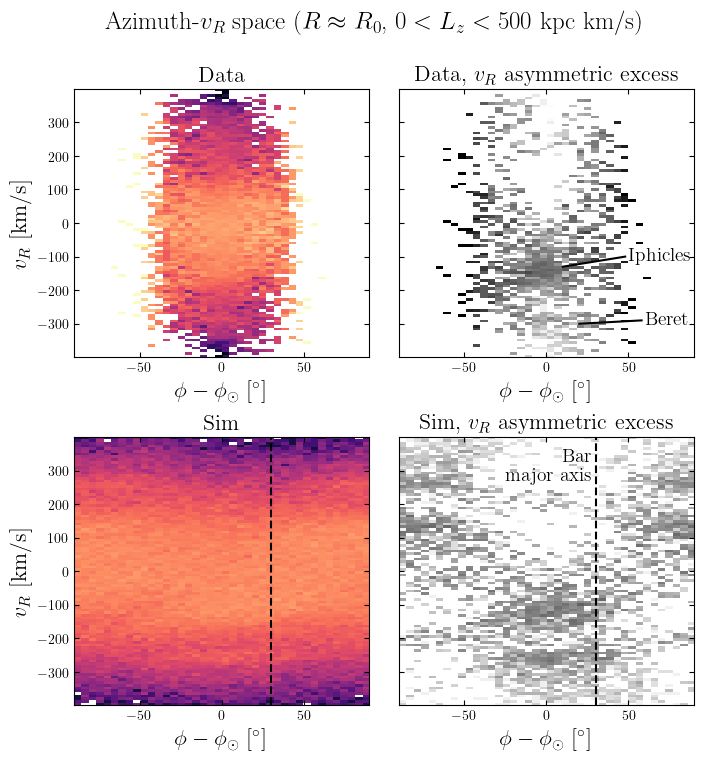

In [20]:
'''Plot phi-vR space'''

fig, axs = plt.subplots(2,2, figsize=(8,8), sharex='row', sharey='row')#, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.3)

# Select Lz, azimuthal and metallicity ranges in which to plot
Lz_max = 500
R_range = 1
z_max = 2
MH_max = 100

# Choose simulation snapshot
snap = -2
print('Omega_b = ', Omega_b_sim[snap])

# Data
cut = (Lz_data > 0)*(Lz_data < Lz_max)*(abs(R_data-R_sun) < R_range)*(abs(z_data) < z_max)#(dist<dist_limit_all)#*(eta_data<0.98)#*(logg<3)

phi_bins = np.linspace(-90, 90, 41)
vR_bins = np.linspace(-400, 400, 101)

hist, _, _ = np.histogram2d(phi_data_sun[cut]*180/np.pi, vR_data[cut], bins=(phi_bins, vR_bins))
hist_smooth = gaussian_filter(hist, (0,0))
hist_smooth_colnorm = hist_smooth / hist_smooth.sum(axis=1)[:,None]
hist_sym = hist + np.flip(hist, axis=1)
hist_smooth_antisym = hist_smooth_colnorm - np.flip(hist_smooth_colnorm, axis=1)
# hist_antisym = gaussian_filter(hist_antisym, 1)


# axs[0,0].imshow(hist_all.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='viridis')
axs[0,0].imshow(hist_smooth_colnorm.T, extent=(phi_bins[0], phi_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='magma')
axs[0,1].imshow(hist_smooth_antisym.T, extent=(phi_bins[0], phi_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='Greys')

# # Hypothesis test for symmetry
# pvalue_array = np.zeros(hist.shape)

# for i in range(pvalue_array.shape[0]):
#     for j in range(pvalue_array.shape[1]):
#         n = int(hist_sym[i,j])
#         k = int(hist[i,j])
#         if n>1:
#             pvalue_array[i,j] = 1 - binomtest(k, n, p=0.5, alternative='greater').pvalue

# axs[0,2].imshow(pvalue_array.T, extent=(phi_bins[0], phi_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', vmin=0.9, vmax=1, cmap='Greys')

# Simulation
cut = (Lz_sim[snap] > 0)*(Lz_sim[snap] < Lz_max)*(abs(R_sim[snap]-R_sun) < R_range)*(abs(z_sim[snap]) < z_max)

hist, _, _ = np.histogram2d(phi_sim_sun[snap,cut]*180/np.pi, vR_sim[snap,cut], bins=(phi_bins, vR_bins))
hist_smooth = gaussian_filter(hist, (0,0))
hist_smooth_colnorm = hist_smooth / hist_smooth.sum(axis=1)[:,None]
hist_sym = hist + np.flip(hist, axis=1)
hist_smooth_antisym = hist_smooth_colnorm - np.flip(hist_smooth_colnorm, axis=1)
# hist_antisym = gaussian_filter(hist_antisym, (0,0.5))
# hist_antisym = gaussian_filter(hist_antisym, 0.5)

# axs[1,0].imshow(hist_0.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='viridis')
axs[1,0].imshow(hist_smooth_colnorm.T, extent=(phi_bins[0], phi_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='magma')
axs[1,1].imshow(hist_smooth_antisym.T, extent=(phi_bins[0], phi_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='Greys')

# # Hypothesis test for symmetry
# pvalue_array = np.zeros(hist.shape)

# for i in range(pvalue_array.shape[0]):
#     for j in range(pvalue_array.shape[1]):
#         n = int(hist_sym[i,j])
#         k = int(hist[i,j])
#         if n>1:
#             pvalue_array[i,j] = 1 - binomtest(k, n, p=0.5, alternative='greater').pvalue

# axs[1,2].imshow(pvalue_array.T, extent=(phi_bins[0], phi_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', vmin=0.9, vmax=1, cmap='Greys')

# res_ratio_list = [0, 0.5, 1, 1.5]
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
# R_grid = np.linspace(0, 20, 10001)
# for j in range(len(res_ratio_list)):
#     vR_res = calc_res_orbit(pot_axi, Omega_b_sim[snap], res_ratio_list[j], 250)
#     axs[1,1].plot(R_grid, vR_res(R_grid), ls='--', c=colors[j], lw=1)
#     axs[1,1].plot(R_grid, -vR_res(R_grid), ls='--', c=colors[j], lw=1)

#     # axs[0,1].plot(R_grid, vR_res(R_grid), ls='--', c=colors[j], lw=1)
#     # axs[0,1].plot(R_grid, -vR_res(R_grid), ls='--', c=colors[j], lw=1)


for ax in axs[:,0].flat:
    ax.set_ylim(-399, 399)
    # ax.set_aspect('equal')
    ax.set_ylabel('$v_R$ [km/s]', fontsize=16)

for ax in axs[1,:].flat:
    ax.axvline(-phi_sun*180/np.pi, ls='--', c='k')

axs[1,1].text(28, 270, 'Bar\nmajor axis', fontsize=14, ha='right')

for ax in axs.flat:
    ax.set_xlim(phi_bins[0], phi_bins[-1])
    ax.set_xlabel('$\phi-\phi_\odot$ [$^\circ$]', fontsize=16)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
    ax.set_rasterization_zorder(10)


axs[0,1].text(50, -110, 'Iphicles', fontsize=14)
axs[0,1].text(60, -300, 'Beret', fontsize=14)

axs[0,1].plot([48,10], [-100, -130], c='k')
axs[0,1].plot([58,20], [-290, -300], c='k')

# axs[0,0].set_title('Data', fontsize=16)
axs[0,0].set_title('Data', fontsize=16)
axs[0,1].set_title('Data, $v_R$ asymmetric excess', fontsize=16)
# axs[0,2].set_title('Data, symmetry hypothesis test', fontsize=16)

# axs[1,0].set_title('Simulation, initial', fontsize=16)
axs[1,0].set_title('Sim', fontsize=16)
axs[1,1].set_title('Sim, $v_R$ asymmetric excess', fontsize=16)
# axs[1,2].set_title('Sim, symmetry hypothesis test', fontsize=16)


fig.suptitle('Azimuth-$v_R$ space ($R\\approx R_0$, $0<L_z<500$ kpc km/s)', fontsize=18, y=0.98)

# axs[0].set_title('$[M/H]<-1$, distance $<1$ kpc', fontsize=16)
# axs[1].set_title('$v_R$ asymmetric excess', fontsize=16)
# plt.xlim(-350, -200)
# plt.ylim(-100, 100)

# plt.savefig(figpath+'phi_vR.pdf', dpi=200, bbox_inches='tight')

plt.show()


Omega_b =  32.50270916353844


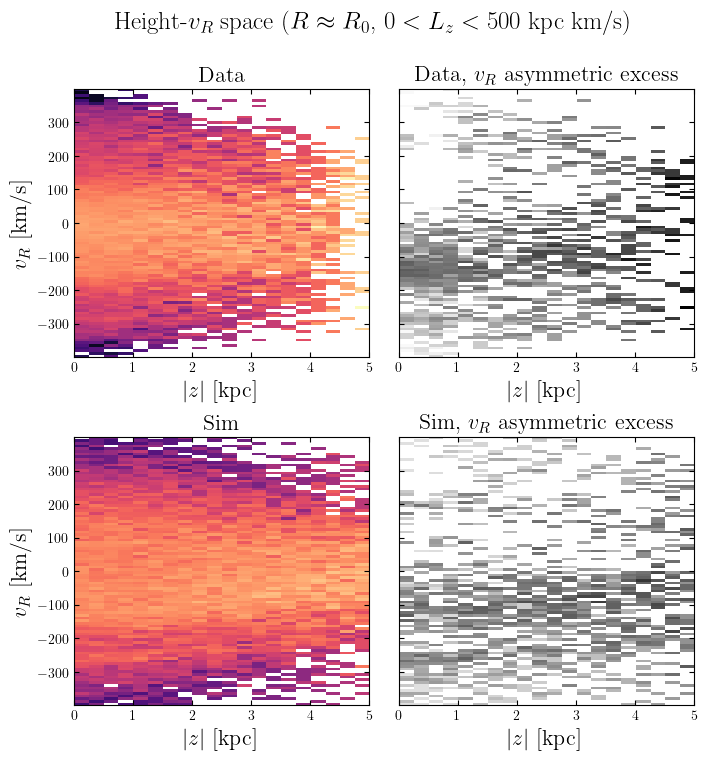

In [16]:
'''Plot z-vR space'''

from scipy.ndimage import gaussian_filter
from scipy.stats import binomtest

fig, axs = plt.subplots(2,2, figsize=(8,8), sharex='row', sharey='row')#, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.3)

# Select Lz, azimuthal and metallicity ranges in which to plot
Lz_max = 500
phi_range = np.pi/12
R_range = 1
MH_max = 100

# Choose simulation snapshot
snap = -2
print('Omega_b = ', Omega_b_sim[snap])

# Data
cut = (Lz_data > 0)*(Lz_data < Lz_max)*(abs(phi_data_sun) < phi_range)*(abs(R_data-R_sun) < R_range)#*(abs(z_data) < z_max)#(dist<dist_limit_all)#*(eta_data<0.98)#*(logg<3)

z_bins = np.linspace(0, 5, 21)
vR_bins = np.linspace(-400, 400, 101)

hist, _, _ = np.histogram2d(abs(z_data)[cut], vR_data[cut], bins=(z_bins, vR_bins))
hist_smooth = gaussian_filter(hist, (0,0))
hist_smooth_colnorm = hist_smooth / hist_smooth.sum(axis=1)[:,None]
# hist_smooth_colnorm[np.isnan(hist_smooth_colnorm)] = 0
hist_sym = hist + np.flip(hist, axis=1)
hist_smooth_antisym = hist_smooth_colnorm - np.flip(hist_smooth_colnorm, axis=1)
# hist_antisym = gaussian_filter(hist_antisym, 1)


# axs[0,0].imshow(hist_all.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='viridis')
axs[0,0].imshow(hist_smooth_colnorm.T, extent=(z_bins[0], z_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='magma')
axs[0,1].imshow(hist_smooth_antisym.T, extent=(z_bins[0], z_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='Greys')

# # Hypothesis test for symmetry
# pvalue_array = np.zeros(hist.shape)

# for i in range(pvalue_array.shape[0]):
#     for j in range(pvalue_array.shape[1]):
#         n = int(hist_sym[i,j])
#         k = int(hist[i,j])
#         if n>1:
#             pvalue_array[i,j] = 1 - binomtest(k, n, p=0.5, alternative='greater').pvalue

# axs[0,2].imshow(pvalue_array.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', vmin=0.9, vmax=1, cmap='Greys')

# Simulation
cut = (Lz_sim[snap] > 0)*(Lz_sim[snap] < Lz_max)*(abs(phi_sim_sun[snap]) < phi_range)*(abs(R_sim[snap]-R_sun) < R_range)#*(abs(trajs[snap,:,2]) < z_max)

hist, _, _ = np.histogram2d(trajs[snap,cut,2], vR_sim[snap,cut], bins=(z_bins, vR_bins))
hist_smooth = gaussian_filter(hist, (0,0))
hist_smooth_colnorm = hist_smooth / hist_smooth.sum(axis=1)[:,None]
hist_sym = hist + np.flip(hist, axis=1)
hist_smooth_antisym = hist_smooth_colnorm - np.flip(hist_smooth_colnorm, axis=1)
# hist_antisym = gaussian_filter(hist_antisym, (0,0.5))
# hist_antisym = gaussian_filter(hist_antisym, 0.5)

# axs[1,0].imshow(hist_0.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='viridis')
axs[1,0].imshow(hist_smooth_colnorm.T, extent=(z_bins[0], z_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='magma')
axs[1,1].imshow(hist_smooth_antisym.T, extent=(z_bins[0], z_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='Greys')

# # Hypothesis test for symmetry
# pvalue_array = np.zeros(hist.shape)

# for i in range(pvalue_array.shape[0]):
#     for j in range(pvalue_array.shape[1]):
#         n = int(hist_sym[i,j])
#         k = int(hist[i,j])
#         if n>1:
#             pvalue_array[i,j] = 1 - binomtest(k, n, p=0.5, alternative='greater').pvalue

# axs[1,2].imshow(pvalue_array.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', vmin=0.9, vmax=1, cmap='Greys')

# res_ratio_list = [0, 0.5, 1, 1.5]
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
# R_grid = np.linspace(0, 20, 10001)
# for j in range(len(res_ratio_list)):
#     vR_res = calc_res_orbit(pot_axi, Omega_b_sim[snap], res_ratio_list[j], 250)
#     axs[1,1].plot(R_grid, vR_res(R_grid), ls='--', c=colors[j], lw=1)
#     axs[1,1].plot(R_grid, -vR_res(R_grid), ls='--', c=colors[j], lw=1)

    # axs[0,1].plot(R_grid, vR_res(R_grid), ls='--', c=colors[j], lw=1)
    # axs[0,1].plot(R_grid, -vR_res(R_grid), ls='--', c=colors[j], lw=1)


for ax in axs[:,0].flat:
    ax.set_ylim(-399, 399)
    # ax.set_aspect('equal')
    ax.set_ylabel('$v_R$ [km/s]', fontsize=16)

for ax in axs.flat:
    # ax.set_xlim(0, 20)
    ax.set_xlabel('$|z|$ [kpc]', fontsize=16)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
    ax.set_rasterization_zorder(10)


# axs[0,1].text(14, 0, 'Iphicles', fontsize=14)
# axs[0,1].text(15, -300, 'Beret', fontsize=14)

# axs[0,1].plot([10,13.9], [-100, 20], c='k')
# axs[0,1].plot([11,14.9], [-220, -280], c='k')

# axs[0,0].set_title('Data', fontsize=16)
axs[0,0].set_title('Data', fontsize=16)
axs[0,1].set_title('Data, $v_R$ asymmetric excess', fontsize=16)
# axs[0,2].set_title('Data, symmetry hypothesis test', fontsize=16)

# axs[1,0].set_title('Simulation, initial', fontsize=16)
axs[1,0].set_title('Sim', fontsize=16)
axs[1,1].set_title('Sim, $v_R$ asymmetric excess', fontsize=16)
# axs[1,2].set_title('Sim, symmetry hypothesis test', fontsize=16)


fig.suptitle('Height-$v_R$ space ($R\\approx R_0$, $0<L_z<500$ kpc km/s)', fontsize=18, y=0.98)

# axs[0].set_title('$[M/H]<-1$, distance $<1$ kpc', fontsize=16)
# axs[1].set_title('$v_R$ asymmetric excess', fontsize=16)
# plt.xlim(-350, -200)
# plt.ylim(-100, 100)

plt.savefig(figpath+'z_vR.pdf', dpi=200, bbox_inches='tight')

plt.show()

In [12]:
'''Functions to integrate and identify resonant orbits'''

# Function to integrate orbits
def test_part_sim(ic, pot, time, trajsize=2, Omega=0, timestart=0):
    
    o = agama.orbit(ic=ic, potential=pot, Omega=Omega, time=time, trajsize=trajsize, timestart=timestart)
    
    ts = o[:,0][0]
    trajs = np.stack(o[:,1]).transpose((1,0,2))

    return trajs, ts

# # Corotation resonance, using phi-phi_b
# def find_corot(orbits):
#     phi_sim = np.arctan2(orbits[:,:,1], orbits[:,:,0])

#     phi_mean = np.mean(phi_sim, axis=0)
#     phi_minus_mean = (phi_sim - phi_mean + np.pi)%(2*np.pi) - np.pi

#     phi_range_frac = (np.max(phi_minus_mean, axis=0) - np.min(phi_minus_mean, axis=0))/(2*np.pi)

#     # Orbits with range of phi less than 90% of 2pi are identified as CR
#     corot_flag = phi_range_frac < 0.9

#     return corot_flag

# Other resonances, using angle variables
def find_res(orbits, freq, pot_axi, Omega_b, l, m):
    af = agama.ActionFinder(pot_axi)

    # Resonant ratio
    l_over_m = l/m

    # Calculate frequency ratio and distance from chosen resonances
    freq_ratio_approx = (freq[:,2] - Omega_b) / freq[:,0]

    res_dist = abs(freq_ratio_approx + l_over_m)

    res_cut_approx = res_dist < 0.1

    # Now calculate angle variables at all snapshots for the stars near the resonance

    res_flag = np.zeros(len(orbits[0]))
    for i in range(len(res_flag)):
        if res_cut_approx[i] == True:
            # print('yes')
            _, ang,_ = af(orbits[:,i], angles=True)

            # Calculate slow angle
            # theta_s = np.unwrap(m*ang[:,2] + l*ang[:,0])

            # theta_s_mean = np.mean(theta_s)
            # theta_s_minus_mean = (theta_s - theta_s_mean + np.pi)%(2*np.pi) - np.pi

            # theta_s_range_frac = (np.max(theta_s_minus_mean) - np.min(theta_s_minus_mean))/(2*np.pi)

            # plt.plot(theta_s)
            # plt.show()
            # plt.close()

            # print(theta_s_range_frac)


            theta_s = np.unwrap(m*ang[:,2] + l*ang[:,0])#np.unwrap(m*ang[:,2] + l*ang[:,0])

            theta_s_rel = theta_s - theta_s[0]

            theta_s_rel_wrap = (theta_s_rel + np.pi) % (2*np.pi) - np.pi
            try:
                zero_index = np.where((np.sign(theta_s_rel_wrap[:-1])*np.sign(theta_s_rel_wrap[1:]) < 0) * (abs(theta_s_rel_wrap[1:] - theta_s_rel_wrap[:-1]) < np.pi))[0][1]
                theta_s_range = np.max(theta_s[:zero_index]) - np.min(theta_s[:zero_index])
                res_flag[i] = theta_s_range/(2*np.pi) < 0.9

            except:
                try:
                    zero_index = np.where((np.sign(theta_s_rel_wrap[:-1])*np.sign(theta_s_rel_wrap[1:]) < 0) * (abs(theta_s_rel_wrap[1:] - theta_s_rel_wrap[:-1]) < np.pi))[0][0]
                    theta_s_range = np.max(theta_s[:zero_index]) - np.min(theta_s[:zero_index])
                    res_flag[i] = theta_s_range/(2*np.pi) < 0.9

                except:
                    res_flag[i] = True

            # res_flag[i] = theta_s_range_frac < 0.9

            del ang, theta_s#, theta_s_minus_mean
    
    del freq_ratio_approx, res_dist, res_cut_approx

    return res_flag


In [13]:
'''Function to integrate orbits and calculate separatrices'''

def calc_res_flags(res_ratio_list, Omega_b_array, eta_array, pot_axi, vR_grid_flat, vphi_grid_flat, int_time=4, trajsize=501):

    # Array of times
    ts = np.linspace(0, int_time, trajsize)

    res_flag_array = np.zeros((len(res_ratio_list), len(Omega_b_array), len(eta_array), len(vR_grid_flat)), dtype=bool)

    # corot_flag_array = np.zeros((len(Omega_b_array), len(eta_array), len(vR_grid_flat)), dtype=bool)
    # OLR_flag_array = np.zeros((len(Omega_b_array), len(eta_array), len(vR_grid_flat)), dtype=bool)
    # res_flag_array = np.zeros((len(Omega_b_array), len(eta_array), len(vR_grid_flat)), dtype=bool)
    # one_to_one_flag_array = np.zeros((len(Omega_b_array), len(eta_array), len(vR_grid_flat)), dtype=bool)
    # ret_OLR_flag_array = np.zeros((len(Omega_b_array), len(eta_array), len(vR_grid_flat)), dtype=bool)
    # orbits_array = np.zeros((len(Omega_b), trajsize, len(vR_grid_flat), 6))

    # Loop over all pattern speeds (or bar angles, potentials, etc.)
    for i in range(len(Omega_b_array)):
        for j in range(len(eta_array)):

            # Calculate angle of slowing bar
            Omega_b_0 = Omega_b_array[i]
            eta = eta_array[j]

            if eta==0:
                phi_b = Omega_b_0 * ts
            
            else:
                phi_b = 1/eta * np.log(1 + eta*Omega_b_0*ts)

            # result = solve_ivp(calc_Omega_b, t_span=(ts[0], ts[-1]), y0=[0], t_eval=ts, args=(Omega_b_0, eta))
            # ts = result.t
            # phi_b_test = result.y[0]

            # Calculate rotation matrix
            rot_mat = np.zeros((len(ts), 6, 6))
            rot_mat[:,0:3,0:3] = np.array([[np.cos(phi_b), np.sin(phi_b), 0*ts], [-np.sin(phi_b), np.cos(phi_b), 0*ts], [0*ts, 0*ts, np.ones(len(ts))]]).transpose(2,0,1)
            rot_mat[:,3:6,3:6] = np.array([[np.cos(phi_b), np.sin(phi_b), 0*ts], [-np.sin(phi_b), np.cos(phi_b), 0*ts], [0*ts, 0*ts, np.ones(len(ts))]]).transpose(2,0,1)

            # Slowing barred potential

            # If integrating back in time, flip time and bar angle arrays for potential creation
            if int_time<0:
                ts_pot = np.flip(ts)
                phi_b_pot = np.flip(phi_b)
            else:
                ts_pot = np.copy(ts)
                phi_b_pot = np.copy(phi_b)


            # Load full, scaled, rotated baryonic potential
            pot_bar_baryon_path = 'MWPotentialHunter24_baryon_full.ini'
            pot_axi_baryon_path = 'MWPotentialHunter24_baryon_axi.ini'

            pot_bar_baryon = agama.Potential(file=agama_pot_path+pot_bar_baryon_path, rotation=np.array([ts_pot, phi_b_pot]).T)
            # And the axisymmetrised, scaled baryonic potential with equal but negative mass
            pot_axi_baryon_neg = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=[-1,1])

            # The sum gives the scaled, rotated non-axisymmetric baryonic components (i.e. the bar)
            # Add these along with the axisymmetric potential (including DM) to get the time-dependent barred potential
            pot_slow = agama.Potential(pot_axi, pot_bar_baryon, pot_axi_baryon_neg)

            # rgrid = np.linspace(0, 20, 101)

            # vcirc = (-rgrid * pot_slow.force(np.array([rgrid, 0*rgrid, 0*rgrid]).T)[:,0])**0.5

            # plt.plot(rgrid, vcirc)
            
            # Set up initial conditions given bar angle (Move this out of the loop later?)
            phi_sun = 2*np.pi-bar_angle

            X_sun = R_sun * np.cos(phi_sun)
            Y_sun = R_sun * np.sin(phi_sun)


            vX_grid = vR_grid_flat * np.cos(-bar_angle) - vphi_grid_flat * np.sin(-bar_angle)
            vY_grid = vR_grid_flat * np.sin(-bar_angle) + vphi_grid_flat * np.cos(-bar_angle)

            ic = np.array([X_sun*np.ones(len(vX_grid)), Y_sun*np.ones(len(vX_grid)), np.zeros(len(vX_grid)), vX_grid, vY_grid, np.zeros(len(vX_grid))+1e-1]).T

            # First calculate frequencies in axisymmetric potential, to identify orbits near resonances
            af = agama.ActionFinder(pot_axi)
            act, ang, freq = af(ic, angles=True)

            # Identify ICs giving orbits near resonances
            # Calculate frequency ratio and distance from nearest resonance
            freq_ratio_approx = (freq[:,2] - Omega_b_0) / freq[:,0]
            nearest_res = np.round(freq_ratio_approx * 2) / 2
            res_dist = abs(freq_ratio_approx - nearest_res)

            # Select only orbits near resonances
            res_cut_approx = res_dist < 0.2
            ic_near_res = ic[res_cut_approx]

            # Steadily rotating bar
            # orbits, ts = test_part_sim(ic, pot_bar, time=int_time, trajsize=trajsize, Omega=Omega_b)

            # Slowing bar
            orbits_near_res, _ = test_part_sim(ic_near_res, pot_slow, time=int_time, trajsize=trajsize)


            orbits = np.zeros((trajsize, len(ic), 6))
            orbits[:,res_cut_approx] = orbits_near_res


            # Rotate coordinates into frame aligned with the bar
            orbits = np.einsum('lij,lmj->lmi', rot_mat, orbits)

            # Identify CR orbits
            for k in range(len(res_ratio_list)):
                res_ratio = res_ratio_list[k]
                res_flag_array[k,i,j] = find_res(orbits, freq, pot_axi, Omega_b_0, res_ratio*2, 2)#find_corot(orbits)
            # corot_flag_array[i,j] = find_corot(orbits)

            # Identify OLR orbits
            # OLR_flag_array[i,j] = find_res(orbits, freq, pot_axi, Omega_b_0, 1, 2)

            # # Identify 1:1 orbits
            #one_to_one_flag_array[i,j] = find_res(orbits, freq, pot_axi, Omega_b_0, 1, 1)

            # # Identify "retrograde OLR" orbits
            # ret_OLR_flag_array[i,j] = find_res(orbits, freq, pot_axi, Omega_b_0, 3, 2)

            # Flag for any resonant orbit
            # res_flag_array[i,j] = np.logical_or(corot_flag_array[i,j], OLR_flag_array[i,j])

            del orbits
            
    del ts

    return res_flag_array


In [14]:
'''Define functions to calculate exact resonances in axisymmetric potential'''

# Calculate frequency ratio given a grid of radial velocities
def calc_freq_ratio(vR_grid, vphi, af, Omega_b, R_sun=R_sun):
    xv = np.array([R_sun*np.ones(len(vR_grid)), np.zeros(len(vR_grid)), np.zeros(len(vR_grid)), vR_grid, vphi*np.ones(len(vR_grid)), np.zeros(len(vR_grid))]).T
    
    act, ang, freq = af(xv, angles=True)
    
    freq_ratio = -(freq[:,2] - Omega_b)/freq[:,0]

    # plt.plot(vR_grid, freq_ratio)
    # plt.show()
    # plt.close()
    
    return freq_ratio

# Calculate tracks of exact resonances
def calc_exact_res(Omega_b, pot_axi, target_res):
    vphi_res = np.linspace(-400, 400, 1001)
    vR_grid_exact = np.linspace(0, 400, 1001)

    af = agama.ActionFinder(pot_axi)

    vR_res = np.zeros(len(vphi_res))

    freq_ratio_array = np.zeros((len(vphi_res), len(vR_grid_exact)))

    for i in range(len(vphi_res)):
        freq_ratio = calc_freq_ratio(vR_grid_exact, vphi_res[i], af, Omega_b)
        freq_ratio_array[i] = freq_ratio
        freq_dist = abs(freq_ratio - target_res)
        vR_res[i] = vR_grid_exact[np.nanargmin(freq_dist)]

    index_nores = (vR_res==0)
    vR_res[index_nores] = np.nan

    vphi_res_full = np.concatenate((np.flip(vphi_res[1:]), vphi_res))
    vR_res_full = np.concatenate((-np.flip(vR_res[1:]), vR_res))
    
    return vR_res_full, vphi_res_full

In [ ]:
'''Set up orbit integrations over grid and calculate separatrices for summary plot'''

# Choose grid over which to integrate orbits
vR_max = 400
vphi_min = -400
vphi_max = 400
grid_step = 2.5 #5
N_grid_R = int(vR_max*2 / grid_step) + 1
N_grid_phi = int((vphi_max - vphi_min) / grid_step) + 1

# vR_bins = np.linspace(-vR_max, vR_max, N_grid_R)
# vphi_bins = np.linspace(vphi_min, vphi_max, N_grid_phi)

vR_bincentres = np.linspace(-vR_max, vR_max, N_grid_R)
vphi_bincentres = np.linspace(vphi_min, vphi_max, N_grid_phi)

vR_grid, vphi_grid = np.meshgrid(vR_bincentres, vphi_bincentres)

vR_bins = np.linspace(-vR_max-grid_step/2, vR_max+grid_step/2, N_grid_R+1)
vphi_bins = np.linspace(vphi_min-grid_step/2, vphi_max+grid_step/2, N_grid_phi+1)

vR_grid_flat = vR_grid.flatten()
vphi_grid_flat = vphi_grid.flatten()

snap = -2
Omega_b = Omega_b_sim[snap]
print('Omega_b =', Omega_b)
eta_sim = 0.003

Omega_b_array = [Omega_b]#np.linspace(30, 40, 11)
eta_array = [0, eta_sim]#np.linspace(0., 0.006, 7)#np.array([0., 0.002, 0.004, 0.006])
bar_angle = 30 * np.pi/180
R_sun = R_sun

int_time = 4
trajsize = 501

res_ratio_list = [0, 0.5, 1, 1.5]

res_flag_array = calc_res_flags(res_ratio_list, Omega_b_array, eta_array, pot_axi, vR_grid_flat, vphi_grid_flat, int_time=int_time, trajsize=trajsize)

# res_index_list = [0, 0.5]
# res_flag_list = [corot_flag, OLR_flag]

Omega_b = 32.50270916353844
83050 orbits complete (790.2 orbits/s)
83050 orbits complete (786.3 orbits/s)


<>:138: SyntaxWarning: invalid escape sequence '\O'
<>:138: SyntaxWarning: invalid escape sequence '\O'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_24737/3225813429.py:138: SyntaxWarning: invalid escape sequence '\O'
  fig.suptitle('Resonances at $\Omega_\mathrm{b}=$ '+f'{Omega_b:.1f}'+' km/s/kpc', fontsize=18, y=0.93)#05)


6 orbits complete (500 orbits/s)


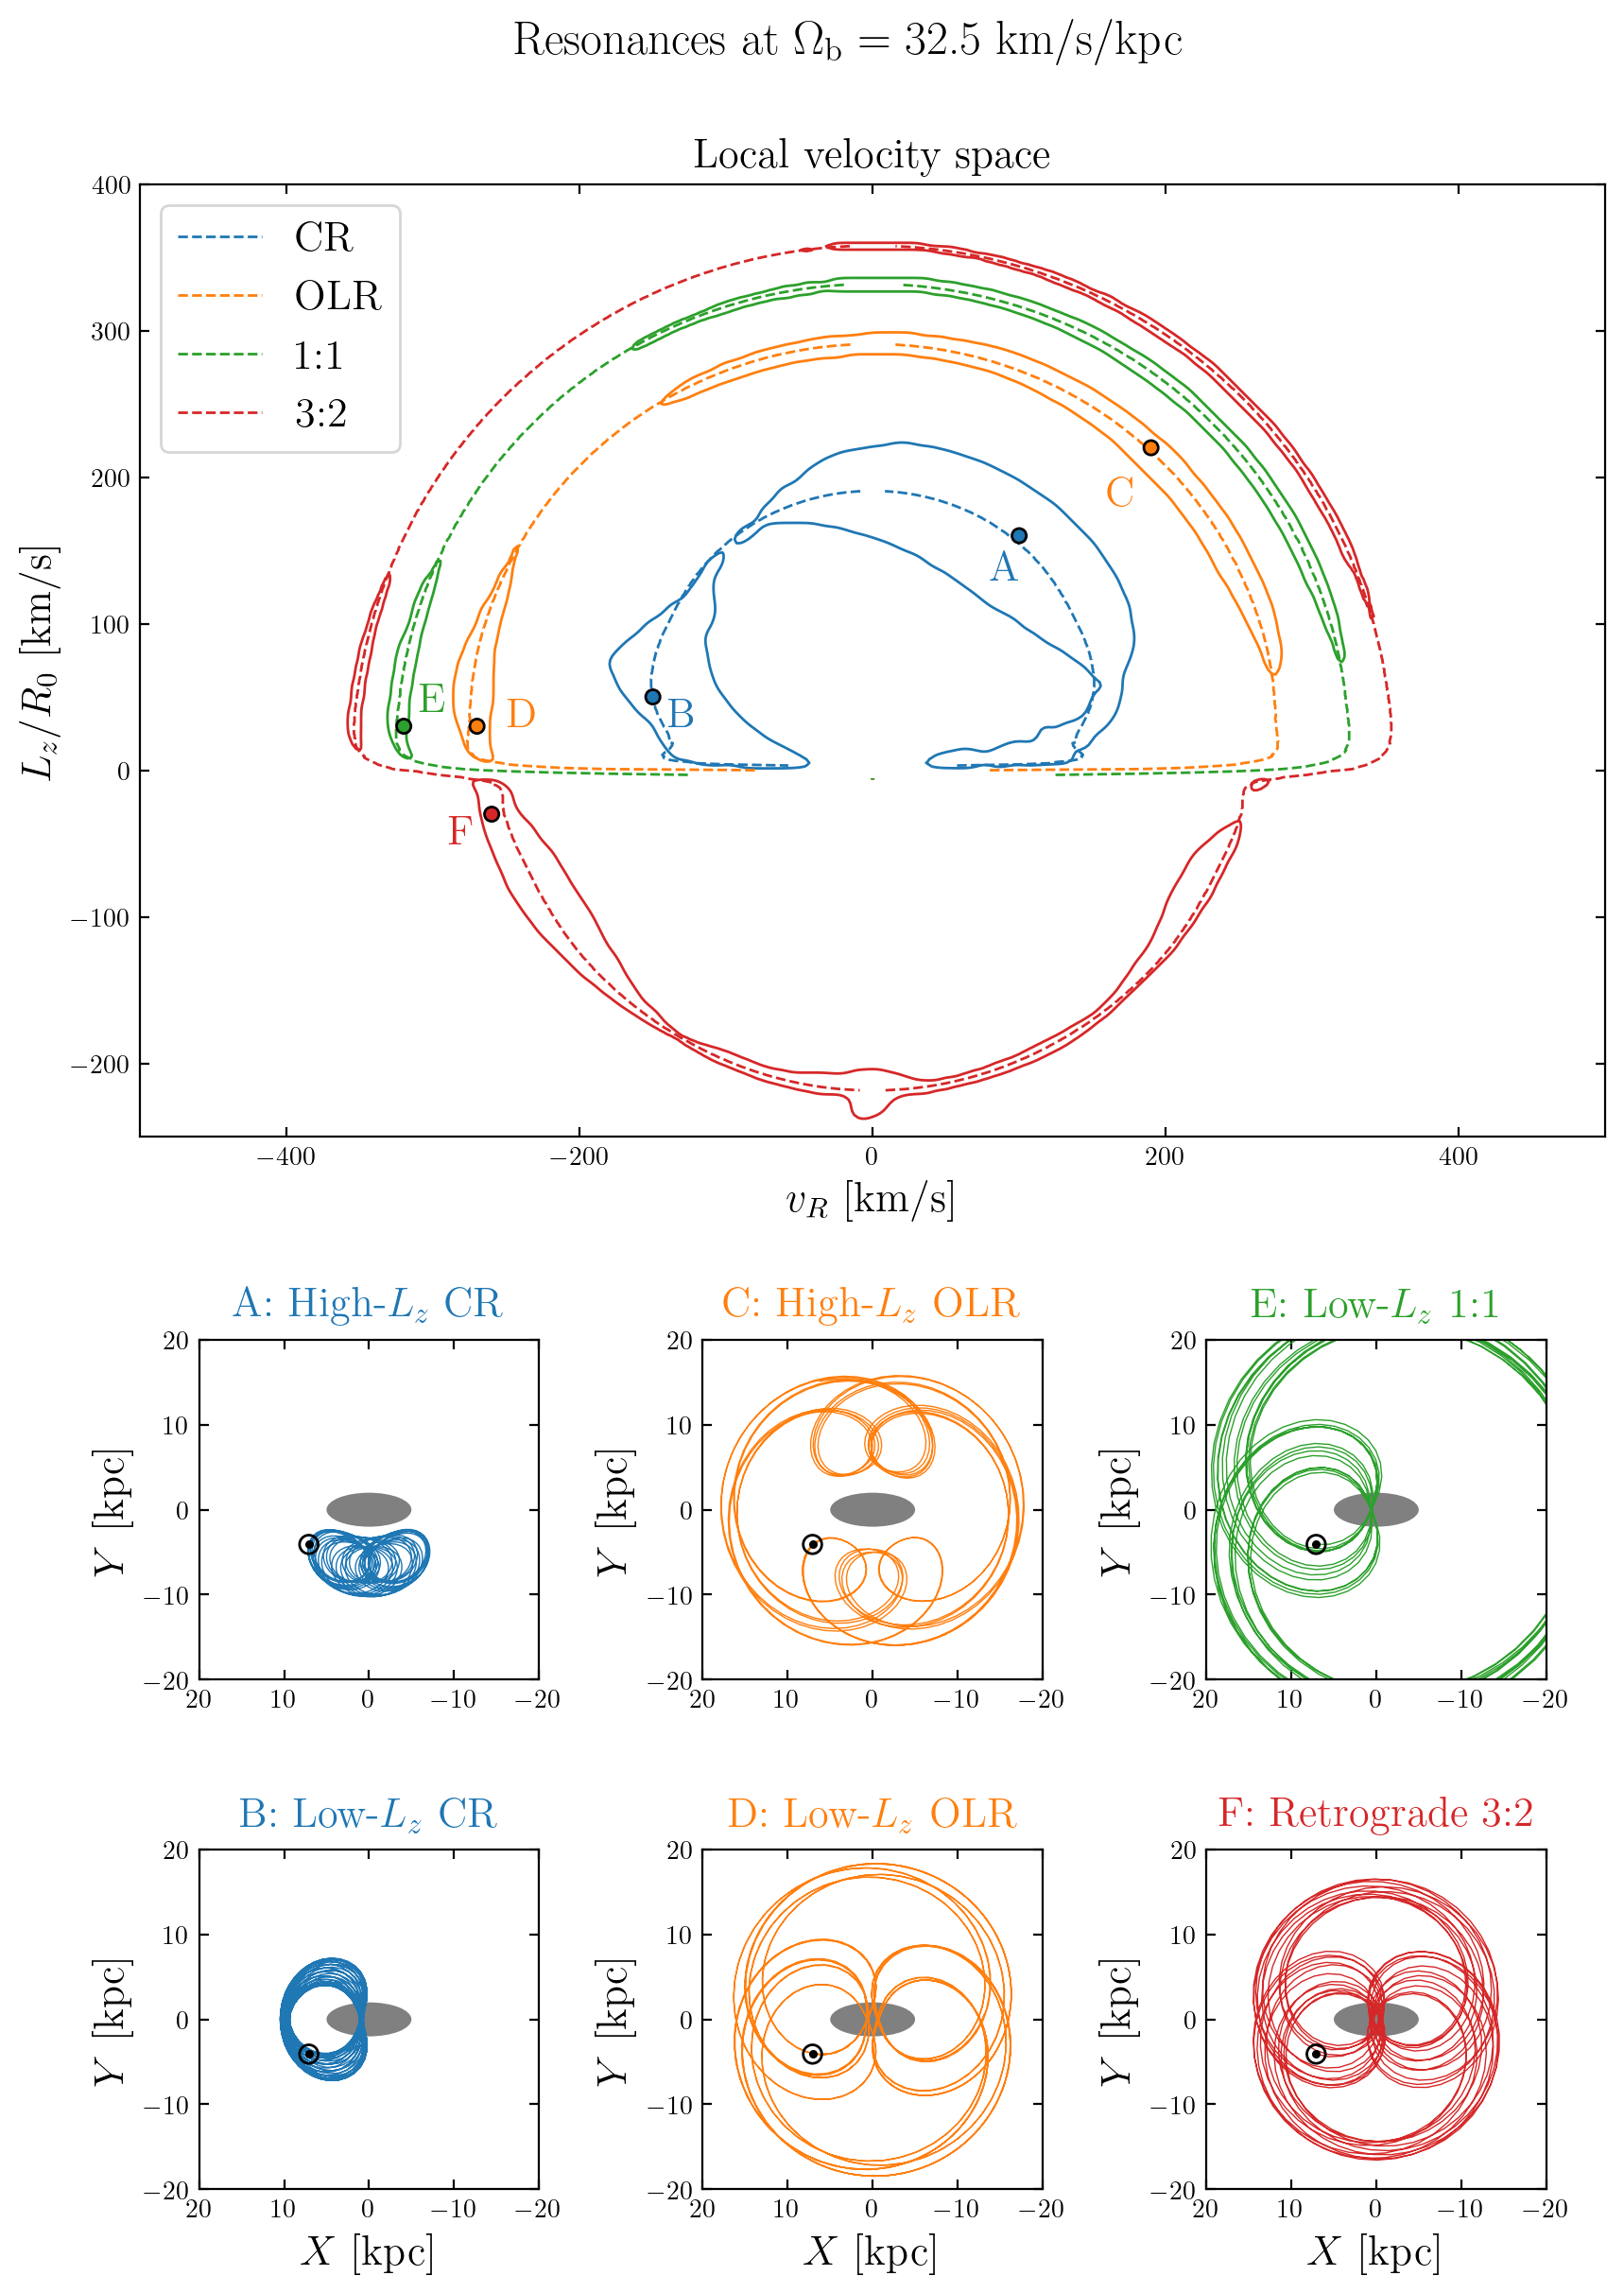

In [52]:
'''Plot separatrices and examples of orbits'''

from matplotlib import gridspec
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from scipy.interpolate import RegularGridInterpolator

# Create a figure
fig = plt.figure(figsize=(10, 14), dpi=200)

# Create a GridSpec layout: 2 rows and 3 columns (last column is used by the top big panel)
# gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[2, 1, 1, 1])
gs = gridspec.GridSpec(3, 3, height_ratios=[3, 1, 1], width_ratios=[1, 1, 1])

# plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.subplots_adjust(hspace=0.3, wspace=0.1)


ax_sep = plt.subplot(gs[0,:])

ax_1 = plt.subplot(gs[1, 0])
ax_2 = plt.subplot(gs[2, 0], sharex=ax_1, sharey=ax_1)
ax_3 = plt.subplot(gs[1, 1], sharex=ax_1, sharey=ax_1)
ax_4 = plt.subplot(gs[2, 1], sharex=ax_1, sharey=ax_1)
ax_5 = plt.subplot(gs[1, 2], sharex=ax_1, sharey=ax_1)
ax_6 = plt.subplot(gs[2, 2], sharex=ax_1, sharey=ax_1)

# ax_sep = plt.subplot(gs[:,0])

# ax_1 = plt.subplot(gs[0, 1])
# ax_2 = plt.subplot(gs[1, 1], sharex=ax_1, sharey=ax_1)
# ax_3 = plt.subplot(gs[0, 2], sharex=ax_1, sharey=ax_1)
# ax_4 = plt.subplot(gs[1, 2], sharex=ax_1, sharey=ax_1)
# ax_5 = plt.subplot(gs[0, 3], sharex=ax_1, sharey=ax_1)
# ax_6 = plt.subplot(gs[1, 3], sharex=ax_1, sharey=ax_1)

axs = [ax_sep, ax_1, ax_2, ax_3, ax_4, ax_5, ax_6]

bins = np.linspace(-400, 400, 101)
bincentres = 0.5*(bins[1:]+bins[:-1])

ax_sep.set_xlim(-500, 500)
ax_sep.set_ylim(-250, 400)

# Choose orbits to plot
peaks = np.array([[100, 160], [-150, 50], [190, 220], [-270, 30], [-320, 30], [-260, -30]])

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ['CR', 'OLR', '1:1', '3:2']
fc = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:green', 'tab:red']#, 'tab:red', 'tab:red']#['k', 'tab:blue', 'tab:red', 'tab:orange']
ec = ['k', 'k', 'k', 'k']
# ax_data.scatter(peaks[:,0], peaks[:,1], marker='o', s=50, fc=fc, ec=ec, zorder=10)
ax_sep.scatter(peaks[:,0], peaks[:,1], marker='o', fc=fc, ec=ec, s=30, zorder=10)

# Set up initial conditions
phi_sun = 2*np.pi-bar_angle

X_sun = R_sun * np.cos(phi_sun)
Y_sun = R_sun * np.sin(phi_sun)

vX_grid = peaks[:,0] * np.cos(-bar_angle) - peaks[:,1] * np.sin(-bar_angle)
vY_grid = peaks[:,0] * np.sin(-bar_angle) + peaks[:,1] * np.cos(-bar_angle)

ic_peaks = np.array([X_sun*np.ones(len(peaks)), Y_sun*np.ones(len(peaks)), np.zeros(len(peaks)), vX_grid, vY_grid, np.zeros(len(peaks))+1e-1]).T

orbits_peaks, ts = test_part_sim(ic_peaks, pot_bar, Omega=Omega_b, time=4, trajsize=1001)
af = agama.ActionFinder(pot_axi)
act, ang, freqs = af(orbits_peaks[:,4], angles=True)

theta_s = np.unwrap(2*ang[:,2] + 3*ang[:,0])


# Also plot separatrices
for k in range(len(res_flag_array)):
    hist, _, _, _ = binned_statistic_2d(vR_grid_flat, vphi_grid_flat, res_flag_array[k,0,0], statistic='mean', bins=(vR_bins, vphi_bins))
    hist_smooth = gaussian_filter(hist, 2)

    ax_sep.contour(vR_bincentres, vphi_bincentres, hist_smooth.T, levels=[0.5], colors=colors[k], linewidths=1)


# Also plot exact resonances in axisymmetric potential
for k in range(len(res_flag_array)):
    vR_res, vphi_res = calc_exact_res(Omega_b, pot_axi, res_ratio_list[k])

    ax_sep.plot(vR_res, vphi_res, ls='--', lw=1, color=colors[k], label=labels[k])


labels = ['A', 'B', 'C', 'D', 'E', 'F']
label_positions = np.array([[80, 130], [-140, 30], [160, 180], [-250, 30], [-310, 40], [-290, -50]])

for i in range(len(peaks)):
    t = ax_sep.text(label_positions[i,0], label_positions[i,1], labels[i], c=fc[i], fontsize=16)
        # ax.axline(label_positions[i])

from matplotlib.patches import Ellipse

for i in range(len(peaks)):
    axs[i+1].plot(orbits_peaks[:,i,0], orbits_peaks[:,i,1], c=fc[i], lw=0.5)
    axs[i+1].scatter(X_sun, Y_sun, ec='k', fc='none', s=50, zorder=10)
    axs[i+1].scatter(X_sun, Y_sun, c='k', marker='o', s=5, zorder=11)
    axs[i+1].set_xlim(20, -20)
    axs[i+1].set_ylim(-20, 20)

for ax in axs[1:]:
    ellipse = Ellipse((0,0), 10, 4, fc='grey')
    ax.add_patch(ellipse)

for ax in axs:
    ax.set_aspect('equal')
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')


ax_sep.set_xlabel('$v_R$ [km/s]', fontsize=16)
ax_sep.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)

ax_2.set_xlabel('$X$ [kpc]', fontsize=16)
ax_4.set_xlabel('$X$ [kpc]', fontsize=16)
ax_6.set_xlabel('$X$ [kpc]', fontsize=16)

ax_1.set_ylabel('$Y$ [kpc]', fontsize=16)
ax_2.set_ylabel('$Y$ [kpc]', fontsize=16)
ax_3.set_ylabel('$Y$ [kpc]', fontsize=16)
ax_4.set_ylabel('$Y$ [kpc]', fontsize=16)
ax_5.set_ylabel('$Y$ [kpc]', fontsize=16)
ax_6.set_ylabel('$Y$ [kpc]', fontsize=16)

ax_sep.set_title('Local velocity space', fontsize=16)
ax_1.set_title('A: High-$L_z$ CR', fontsize=16, c=fc[0], y=1.02)
ax_2.set_title('B: Low-$L_z$ CR', fontsize=16, c=fc[1], y=1.02)
ax_3.set_title('C: High-$L_z$ OLR', fontsize=16, c=fc[2], y=1.02)
ax_4.set_title('D: Low-$L_z$ OLR', fontsize=16, c=fc[3], y=1.02)
ax_5.set_title('E: Low-$L_z$ 1:1', fontsize=16, c=fc[4], y=1.02)
ax_6.set_title('F: Retrograde 3:2', fontsize=16, c=fc[5], y=1.02)

ax_sep.legend(loc=2, fontsize=16, ncols=1)

fig.suptitle('Resonances at $\Omega_\mathrm{b}=$ '+f'{Omega_b:.1f}'+' km/s/kpc', fontsize=18, y=0.93)#05)


plt.savefig(figpath+'separatrices.pdf', bbox_inches='tight')

plt.show()
plt.close()


<>:115: SyntaxWarning: invalid escape sequence '\O'
<>:115: SyntaxWarning: invalid escape sequence '\O'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_24737/2966790804.py:115: SyntaxWarning: invalid escape sequence '\O'
  fig.suptitle('Resonances at $\Omega_\mathrm{b}=$ '+f'{Omega_b:.1f}'+' km/s/kpc', fontsize=18, y=0.75)


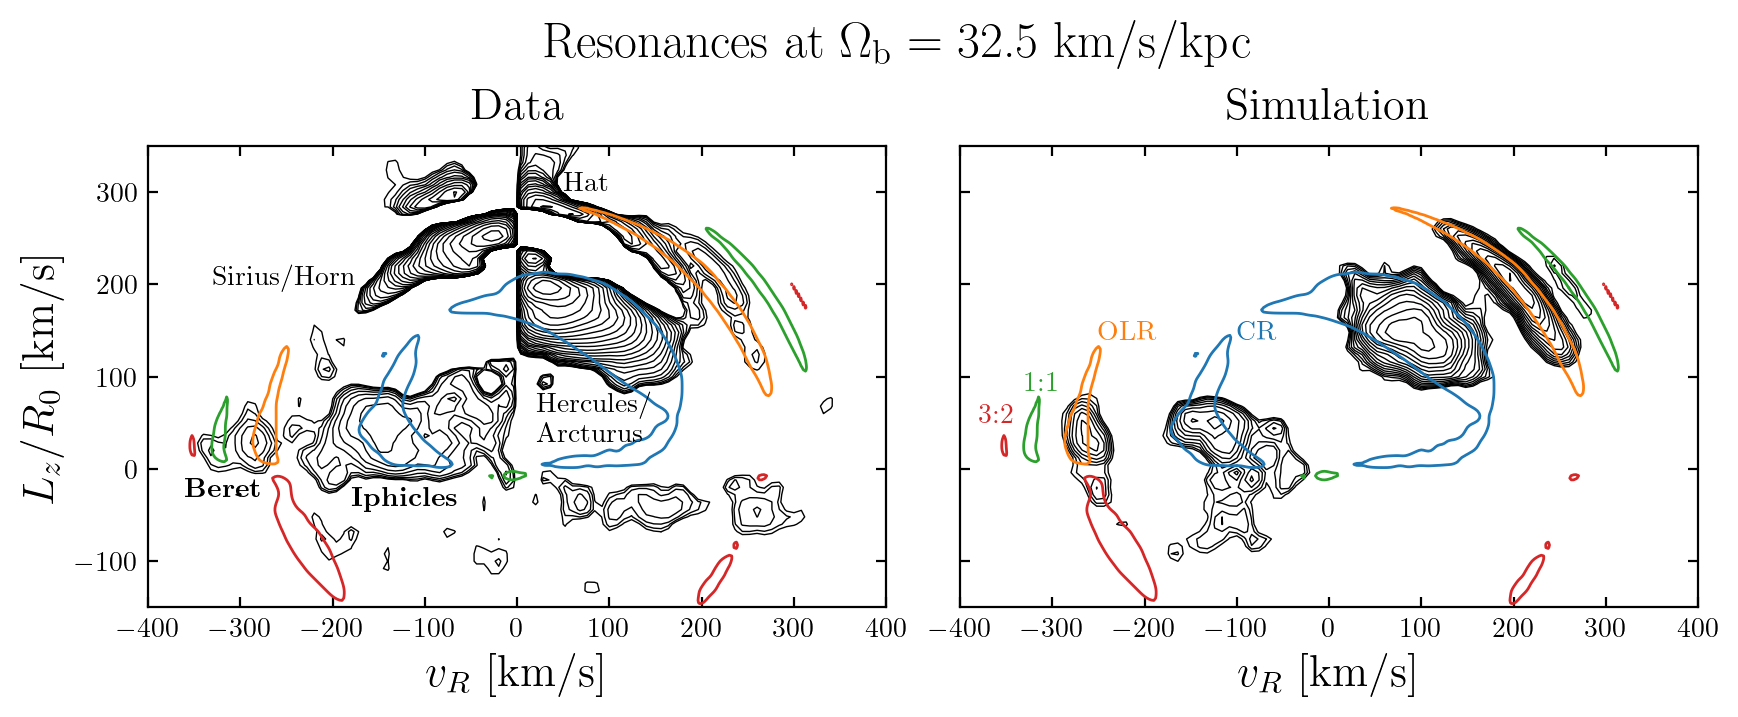

In [91]:
'''Plot antisymmetric distributions of data and simulations with resonances'''

from matplotlib import gridspec
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from scipy.interpolate import RegularGridInterpolator

fig, axs = plt.subplots(1,2, figsize=(10, 7), dpi=200, sharex=True, sharey=True)

plt.subplots_adjust(hspace=0.4, wspace=0.1)

ax_data = axs[0]
ax_sim = axs[1]

# Select radial, azimuthal and metallicity ranges in which to plot
MH_max = 10#-0.5
R_range = 1
z_max = 2
phi_range = np.pi/12


# Data
cut = (MH < MH_max)*(abs(R_data - R_sun) < R_range)*(abs(phi_data_sun) < phi_range)*(abs(z_data) < z_max)#(dist<dist_limit)

bins = np.linspace(-400, 400, 101)
bincentres = 0.5*(bins[1:]+bins[:-1])

hist, _, _ = np.histogram2d(vR_data[cut], vphi_data[cut]*R_data[cut]/R_sun, bins=bins)
hist_smooth = gaussian_filter(hist, 1)

hist_antisym = hist - np.flip(hist, axis=0)
hist_antisym_smooth = gaussian_filter(hist_antisym, 1)

# ax_data.contourf(bincentres, bincentres, hist_antisym_smooth.T, levels=np.logspace(0.3, 5, 30), cmap='Greys', norm=mcolors.LogNorm())
ax_data.contour(bincentres, bincentres, hist_antisym_smooth.T, levels=np.logspace(0.3, 5, 30), colors='k', linewidths=0.5)
ax_data.set_xlim(-400, 400)
ax_data.set_ylim(-150, 350)


# Simulation
cut = (abs(R_sim[snap] - R_sun) < R_range)*(abs(phi_sim[snap]%np.pi - 5/6*np.pi) < phi_range)*(abs(z_sim[snap]) < z_max)

hist, _, _ = np.histogram2d(vR_sim[snap,cut], vphi_sim[snap,cut]*R_sim[snap,cut]/R_sun, bins=bins)
hist_smooth = gaussian_filter(hist, 1)

hist_antisym = hist - np.flip(hist, axis=0)
hist_antisym_smooth = gaussian_filter(hist_antisym, 1)

# ax_sim.contourf(bincentres, bincentres, hist_antisym_smooth.T, levels=np.logspace(0.3, 2, 20), cmap='Greys', norm=mcolors.LogNorm())
ax_sim.contour(bincentres, bincentres, hist_antisym_smooth.T, levels=np.logspace(0.9, 2, 20), colors='k', linewidths=0.5)
ax_sim.set_xlim(-400, 400)
ax_sim.set_ylim(-150, 350)


# ax_data.scatter(peaks[:,0], peaks[:,1], marker='o', fc=fc, ec=ec, s=30, zorder=10)
# ax_sim.scatter(peaks[:,0], peaks[:,1], marker='o', fc=fc, ec=ec, s=30, zorder=10)


# Also plot separatrices
for k in range(len(res_flag_array)):
    hist, _, _, _ = binned_statistic_2d(vR_grid_flat, vphi_grid_flat, res_flag_array[k,0,1], statistic='mean', bins=(vR_bins, vphi_bins))
    hist_smooth = gaussian_filter(hist, 2)

    # ax_data.contour(vR_bincentres, vphi_bincentres, hist_smooth.T, levels=[0.5], colors=colors[k], linewidths=1)
    ax_data.contour(vR_bincentres, vphi_bincentres, hist_smooth.T, levels=[0.5], colors=colors[k], linewidths=1)

    hist, _, _, _ = binned_statistic_2d(vR_grid_flat, vphi_grid_flat, res_flag_array[k,0,1], statistic='mean', bins=(vR_bins, vphi_bins))
    hist_smooth = gaussian_filter(hist, 2)

    # ax_data.contour(vR_bincentres, vphi_bincentres, hist_smooth.T, levels=[0.5], colors=colors[k], linewidths=1)
    ax_sim.contour(vR_bincentres, vphi_bincentres, hist_smooth.T, levels=[0.5], colors=colors[k], linewidths=1)


# Also plot exact resonances in axisymmetric potential
# for k in range(len(res_flag_array)):
#     vR_res, vphi_res = calc_exact_res(Omega_b, pot_axi, res_ratio_list[k])

#     ax_data.plot(vR_res, vphi_res, ls='--', lw=1, color=colors[k])
#     ax_sim.plot(vR_res, vphi_res, ls='--', lw=1, color=colors[k])


# Point labels
labels = ['A', 'B', 'C', 'D', 'E', 'F']
label_positions = np.array([[80, 40], [-200, 90], [170, 130], [-230, 10], [-360, -30], [-300, -70]])

# for i in range(len(peaks)):
    # ax_sim.text(label_positions[i,0], label_positions[i,1], labels[i], c=fc[i], fontsize=16)

ax_data.text(20, 30, 'Hercules/\nArcturus')
ax_data.text(-330, 200, 'Sirius/Horn')
ax_data.text(50, 300, 'Hat')

ax_data.text(-180, -40, '$\\bf{Iphicles}$')
ax_data.text(-360, -30, '$\\bf{Beret}$')

ax_sim.text(-100, 140, 'CR', color=colors[0])
ax_sim.text(-250, 140, 'OLR', color=colors[1])
ax_sim.text(-330, 85, '1:1', color=colors[2])
ax_sim.text(-380, 50, '3:2', color=colors[3])

for ax in axs:
    ax.set_aspect('equal')
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
    ax.set_rasterization_zorder(10)

ax_data.set_xlabel('$v_R$ [km/s]', fontsize=16)
ax_sim.set_xlabel('$v_R$ [km/s]', fontsize=16)
ax_data.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)
# ax_sim.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)

ax_data.set_title('Data', fontsize=16, y=1.02)
ax_sim.set_title('Simulation', fontsize=16, y=1.02)

fig.suptitle('Resonances at $\Omega_\mathrm{b}=$ '+f'{Omega_b:.1f}'+' km/s/kpc', fontsize=18, y=0.75)

plt.savefig(figpath+'data_sim_seps.pdf', bbox_inches='tight')


In [505]:
'''[FROM HERE ON NOT USED IN PAPER]'''

'''Define function to calculate overlap between antisymmetric overdensities and resonances'''
# from scipy.ndimage import gaussian_filter
# from scipy.special import factorial

def calc_overlap(vR, vphi, bins, hist_res_smooth):

    # Calculate antisymmetric histogram
    hist, _, _ = np.histogram2d(vR, vphi, bins=bins)
    hist_antisym = 0.5 * (hist - np.flip(hist, axis=0))
    hist_antisym[hist_antisym < 0] = 0
    hist_antisym_smooth = gaussian_filter(hist_antisym, 1)

    # # Set all negative parts to zero (no loss of information - positive excess used instead)
    hist_antisym_smooth[hist_antisym_smooth < 1] = 0

    # Divide up antisymmetrised histogram into different resonant regions
    hist_antisym_smooth_CR = hist_antisym_smooth * (vR_grid.T > -250)
    hist_antisym_smooth_CR_0 = hist_antisym_smooth * (vR_grid.T > 0)
    hist_antisym_smooth_CR_1 = hist_antisym_smooth * (vR_grid.T > -250) * (vR_grid.T < 0)
    hist_antisym_smooth_OLR = hist_antisym_smooth * (vR_grid.T  < -250)

    # Normalise histograms
    hist_antisym_smooth_all = hist_antisym_smooth / hist_antisym_smooth.sum()
    hist_antisym_smooth_CR = hist_antisym_smooth_CR / hist_antisym_smooth_CR.sum()
    hist_antisym_smooth_CR_0 = hist_antisym_smooth_CR_0 / hist_antisym_smooth_CR_0.sum()
    hist_antisym_smooth_CR_1 = hist_antisym_smooth_CR_1 / hist_antisym_smooth_CR_1.sum()
    hist_antisym_smooth_OLR = hist_antisym_smooth_OLR / hist_antisym_smooth_OLR.sum()

    # hist_CR_smooth_norm = hist_res_smooth[0] / hist_res_smooth[0].sum()
    # hist_OLR_smooth_norm = hist_res_smooth[1] / hist_res_smooth[1].sum()

    # Calculate overlap of resonance flag and antisymmetrised histogram
    overlap_all = hist_res_smooth * hist_antisym_smooth_all
    overlap_CR = hist_res_smooth * hist_antisym_smooth_CR
    overlap_CR_0 = hist_res_smooth * hist_antisym_smooth_CR_0
    overlap_CR_1 = hist_res_smooth * hist_antisym_smooth_CR_1
    overlap_OLR = hist_res_smooth * hist_antisym_smooth_OLR

    overlap_tot_all = overlap_all.sum()
    overlap_tot_CR = overlap_CR.sum()
    overlap_tot_CR_0 = overlap_CR_0.sum()
    overlap_tot_CR_1 = overlap_CR_1.sum()
    overlap_tot_OLR = overlap_OLR.sum()

    print(overlap_tot_CR_0)

    overlap_array = np.array([overlap_tot_CR_0, overlap_tot_CR_1, overlap_tot_OLR])

    # log_likelihood_list = [np.log(prob_CR_0), np.log(prob_CR_1), np.log(prob_OLR)]
    # print(hist_antisym_smooth_CR.sum())

    # print(prob_CR_0)
    # print(log_likelihood_list[0])

    # plt.imshow(overlap_CR_0.T, origin='lower', cmap='gray_r', interpolation='none', vmin=0, vmax=0.1)
    # plt.show()
    # plt.close()
    
    return overlap_array


In [ ]:
'''Calculate overlap [NOT USED IN PAPER]'''
from scipy.stats import binned_statistic_2d

# Cut data
cut = (MH < -1)*(dist<2)

# Save log likelihood separately for different resonances
log_likelihood_corot_array = np.zeros((len(Omega_b_array), len(eta_array)))
log_likelihood_OLR_array = np.zeros((len(Omega_b_array), len(eta_array)))
overlap_array = np.zeros((len(Omega_b_array), len(eta_array), 3))

# Loop over all pattern speeds (or bar angles, potentials, etc.)
for i in range(len(Omega_b_array)):
    for j in range(len(eta_array)):

        res_flag = np.logical_or(corot_flag_array[i,j], OLR_flag_array[i,j])
        res_flag = np.logical_or(one_to_one_flag_array[i,j], res_flag)

        # Smooth resonance flag over the scale of a pixel
        hist_res, _, _, _ = binned_statistic_2d(vR_grid_flat, vphi_grid_flat, res_flag, statistic='mean', bins=(vR_bins, vphi_bins))
        # hist_res_sym = np.logical_or(hist_res, np.flip(hist_res, axis=0))
        
        hist_res_smooth = gaussian_filter(hist_res.astype(float), 1)

        overlap_array[i,j] = calc_overlap(vR_data[cut], vphi_data[cut], bins=(vR_bins, vphi_bins), hist_res_smooth=hist_res_smooth)

        # print(log_likelihood_array[i,j])


0.4203082781001507
0.3983323299832912
0.3645339516159233
0.32838551125976273
0.2964638595592172
0.2537408369749106
0.19816694437715085
0.5856512181563392
0.5752737265438487
0.5399060170833553
0.5054245864147014
0.4769842013819523
0.41340389044415615
0.33954041763343673
0.7274554892384497
0.7161193283653413
0.691310848972563
0.6651247891491192
0.6318851850563755
0.5418188336022527
0.45881455964537
0.8261403039633785
0.8208313302505658
0.8048841198502353
0.7827471963534464
0.7276826959319644
0.6086519901854831
0.5161412892518874
0.8613960270674988
0.8588313824934967
0.8498483450240444
0.8324138698364185
0.7425292222192138
0.6031142155935937
0.4930553992859175
0.8643439936321456
0.8606185572243747
0.8501248666103799
0.8154756636964884
0.7015523538061309
0.5578458121924723
0.4340835582373603
0.8315227250906938
0.8296942491502436
0.8217724724584171
0.7746842584627404
0.6475397920314611
0.4950447378387025
0.37206892239913986
0.7613134243460224
0.759460020395188
0.7472010197871951
0.702825469

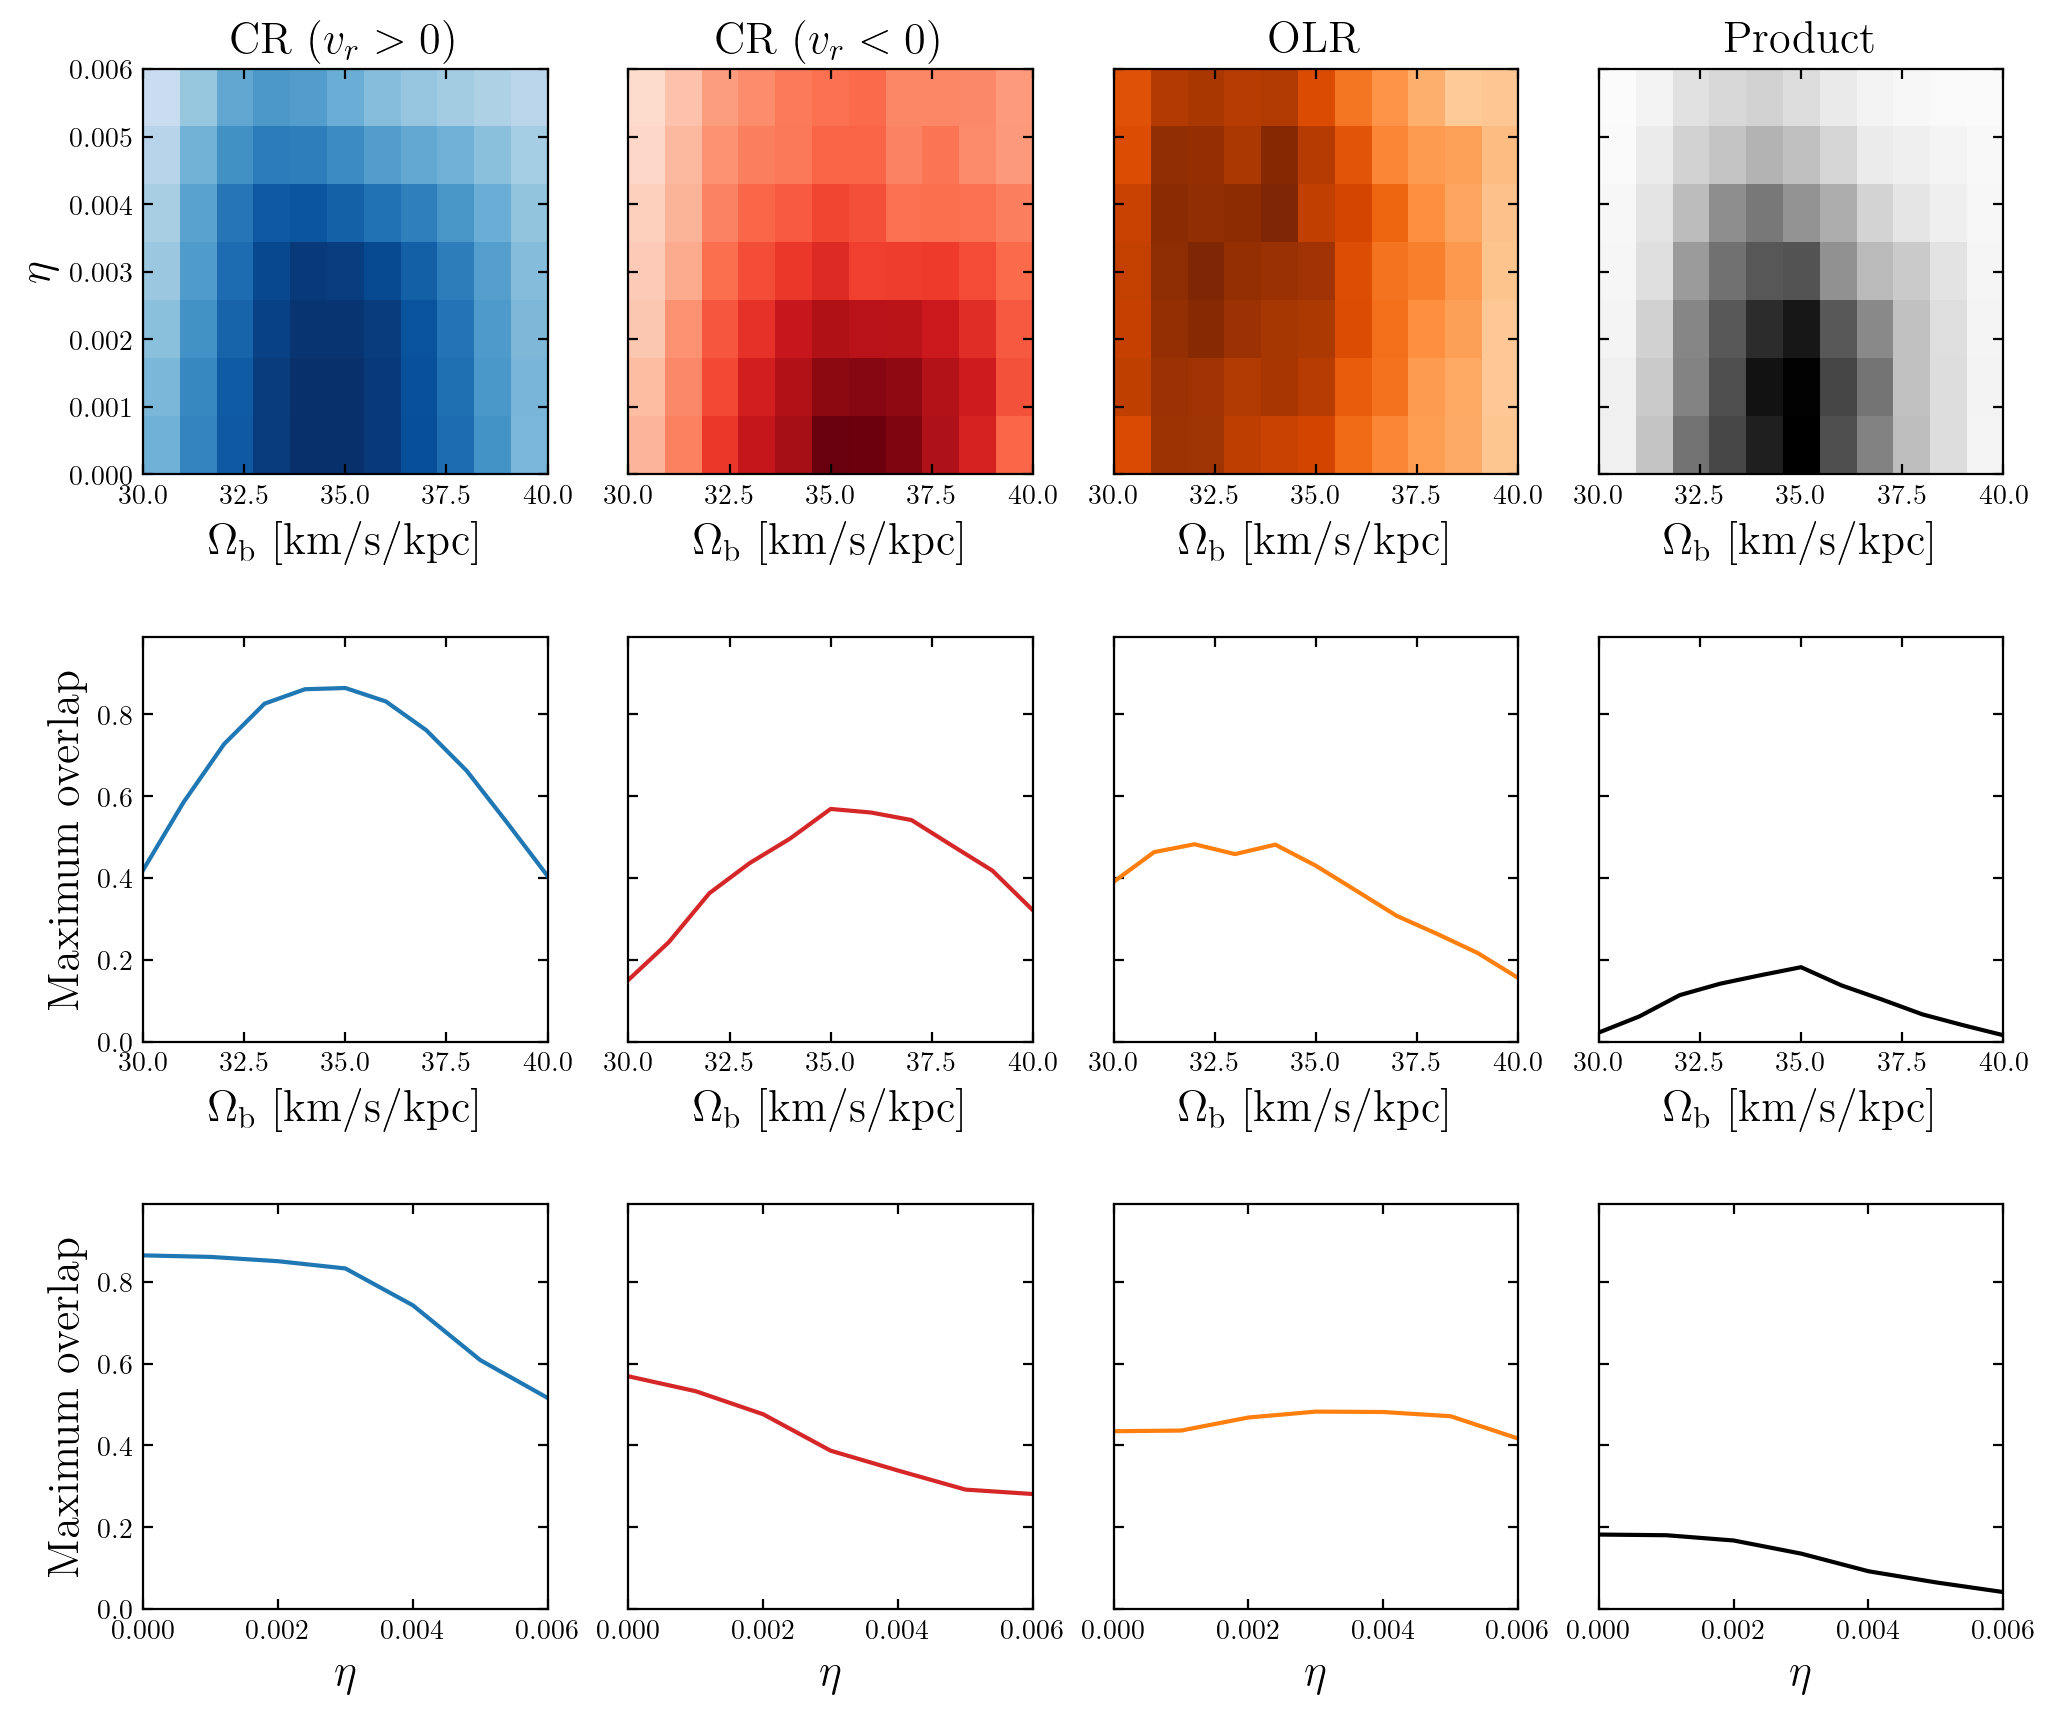

In [ ]:
'''Plot overlap vs model parameters [NOT USED IN PAPER]'''

# plt.plot(Omega_b_array, log_likelihood_corot_array)
# plt.plot(Omega_b_array, log_likelihood_OLR_array)
# plt.plot(Omega_b_array, log_likelihood_array)

fig, axs = plt.subplots(3, overlap_array.shape[-1]+1, figsize=(12, 10), sharex='row', sharey='row', dpi=200)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

product = np.prod(overlap_array, axis=-1)



colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:gray']
cmaps = ['Blues', 'Reds', 'Oranges', 'Greys']
# linestyles = ['--', ':', '-', '-']
labels = ['CR ($v_r>0$)', 'CR ($v_r<0$)', 'OLR', 'Product']

for k in range(overlap_array.shape[-1]):
    # norm = np.exp(log_likelihood_array[:,:,k]).sum()
    axs[0,k].imshow(overlap_array[:,:,k].T, extent=[Omega_b_array[0], Omega_b_array[-1], eta_array[0], eta_array[-1]], cmap=cmaps[k], aspect='auto', origin='lower', vmin=0, vmax=np.max(overlap_array[:,:,k]))
    axs[1,k].plot(Omega_b_array, np.max(overlap_array[:,:,k], axis=1), c=colors[k], label=labels[k])
    axs[2,k].plot(eta_array, np.max(overlap_array[:,:,k], axis=0), c=colors[k], label=labels[k])

for k in range(overlap_array.shape[-1]+1): 
    axs[0,k].set_xlabel('$\Omega_\mathrm{b}$ [km/s/kpc]', fontsize=16)
    axs[1,k].set_xlabel('$\Omega_\mathrm{b}$ [km/s/kpc]', fontsize=16)
    axs[2,k].set_xlabel('$\eta$', fontsize=16)
    axs[0,k].set_title(labels[k], fontsize=16)

axs[0,0].set_ylabel('$\eta$', fontsize=16)
axs[1,0].set_ylabel('Maximum overlap', fontsize=16)
axs[2,0].set_ylabel('Maximum overlap', fontsize=16)

axs[0,-1].imshow(product.T, extent=[Omega_b_array[0], Omega_b_array[-1], eta_array[0], eta_array[-1]], cmap=cmaps[-1], aspect='auto', origin='lower', vmin=0, vmax=np.max(product))
axs[1,-1].plot(Omega_b_array, product[:,0], c='k', label=labels[-1])
axs[2,-1].plot(eta_array, product[5,:], c='k', label=labels[-1])


# axs[1].legend(ncols=2)

axs[0,0].set_xlim(min(Omega_b_array), max(Omega_b_array))
axs[1,0].set_xlim(min(Omega_b_array),max(Omega_b_array))
axs[1,0].set_ylim(0,0.99)
axs[2,0].set_xlim(min(eta_array),max(eta_array))
axs[2,0].set_ylim(0,0.99)

for ax in axs.flat:
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

